***

# <span style="color:blue">**Data analysis on the [Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts) dataset from Kaggle available under the [Open Database License (ODbL)](https://opendatacommons.org/licenses/odbl/1-0/)**</span>

### Tasks to be achieved:

    A. Data import and high level exploration
    B. In depth-analysis
    C. Text data    
    D. Time-Series analysis
    E. Build a database
    F. Finding correlations

### Summary of the cleaning procedure before starting the analysis (Task A): 

1. Drop columns where all entries are NaN
2. Drop columns with more than 75% of missing entries
3. Drop rows if nutrional score is NaN
4. Drop rows where the basic nutritional content is missing:
    * energy
    * fats & saturated fats
    * carbs and sugars
    * fibers
    * salt
5. Drop rows if the following are missing since they are needed in the analysis:
    * ingredients text
    * product name
    * number of additives
    * countries
6. Drop numerical columns after checking their correlation and drop categorical columns after checking their content that will not be used in the analysis in order to facilitate further the cleaning of NaNs
7. Text normalization on ingredients text and product name in order for the latter to find duplicated entries

### Questions explored in Task B: 

1. Are the number of additives correlated with the nutrition score?
2. How the products are classified according to their risk?
3. Are there countries with more or less risky additives?
4. Which product categories have more risky additives?
5. Which product category is most prone to have many additives?

***

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # for compiling regular expressions
import seaborn as sns


***
# <span style="color:blue">**Task A: Exploratory Data Analysis**</span>
***

***
### **Load data into a dataframe**

To be able to read correctly the text file and load it into a dataframe, the `low_memory` parameter of the `read_csv` method has to be set to `False` to suppress the message that is thrown if otherwise:

`DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types`
***

In [2]:
df=pd.read_csv('en.openfoodfacts.org.products.tsv', sep='\t', low_memory=False) 

***
### **Get basic info**

To be able to see all the `Columns` of the dataframe with their corresponding `Non-Null Counts` and their `Dtype`, the `verbose` and `null_counts` parameters of the `info` function have to be set both to `True` due to memory issues (`memory usage is 442.8+ MB`).
***

In [3]:
# get the info from the dataframe
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 163 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        356001 non-null  object 
 1   url                                         356001 non-null  object 
 2   creator                                     356024 non-null  object 
 3   created_t                                   356024 non-null  object 
 4   created_datetime                            356017 non-null  object 
 5   last_modified_t                             356027 non-null  object 
 6   last_modified_datetime                      356027 non-null  object 
 7   product_name                                338515 non-null  object 
 8   generic_name                                57714 non-null   object 
 9   quantity                                    119285 non-null  object 


***
Up to here we see that we corectly read the dataframe. There are:
* `356027 entries`
* `163 columns` of which `107` are of `Dtype float64` and `56` of `Dtype object`. From the 56 columns, the 15 of them (columns: 0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) that we got from the DtypeWarning that we suppress have in principle mixed types that we should keep in mind if we need to use them.

We see also that there are many columns with a lot of NaN values as well as columns that are completely empty (0 non-null) or have very few entries. We can already at this stage drop all the 16 columns with 0 entries and the rest we will see afterwards.
***

***
### **Drop the 16 columns that do not have entries at all**

We should be left with 147 columns
***

In [4]:
df.dropna(axis=1, how='all', inplace=True)
df.shape # get the shape of the dataframe

(356027, 147)

***
### **Check how the dataframe looks like before proceeding to cleaning**
***

In [5]:
# check the last 4 entries
pd.set_option('display.max_columns', 147)
df.tail(4)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-montanic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
356023,9970229501521,http://world-en.openfoodfacts.org/product/9970...,tomato,1422099377,2015-01-24T11:36:17Z,1491244499,2017-04-03T18:34:59Z,乐吧泡菜味薯片,Leba pickle flavor potato chips,50 g,Plastique,plastique,乐吧,乐吧,Potato chips,"en:salty-snacks,en:appetizers,en:chips-and-fri...","Salty snacks,Appetizers,Chips and fries,Crisps...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,China,en:china,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Salty snacks,Appetizers,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",en:salty-snacks,Salty snacks,http://en.openfoodfacts.org/images/products/99...,http://en.openfoodfacts.org/images/products/99...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356024,9977471758307,http://world-en.openfoodfacts.org/product/9977...,openfoodfacts-contributors,1497018549,2017-06-09T14:29:09Z,1500730305,2017-07-22T13:31:45Z,Biscottes bio,NaN,300g,NaN,NaN,Leader Price,leader-price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,

***
From a quick look on the data we can observe already that there are columns:
  * with text that do not have the same alphabet as for e.g. `product_name, brands, brands_tags` with `country_tag` or `country_en` (the country were the products are sold) from China but the `generic_name` and the `categories` are in english. There are also products in French;
  * that are not needed at all in the context of this analysis as for e.g. `images` and `urls`;
  * with the same content but in different format as for e.g. `unix timestamp` and `datetime` or writting format as for e.g. `packaging, brands, categories, states, additives, categories` etc.
***  

***
### **Plot the remaining NaN values of each column by calculated their percentage wrt the total number of entries.**

The information of the percentage is needed afterwards in order to define a threshold to drop columns.
***

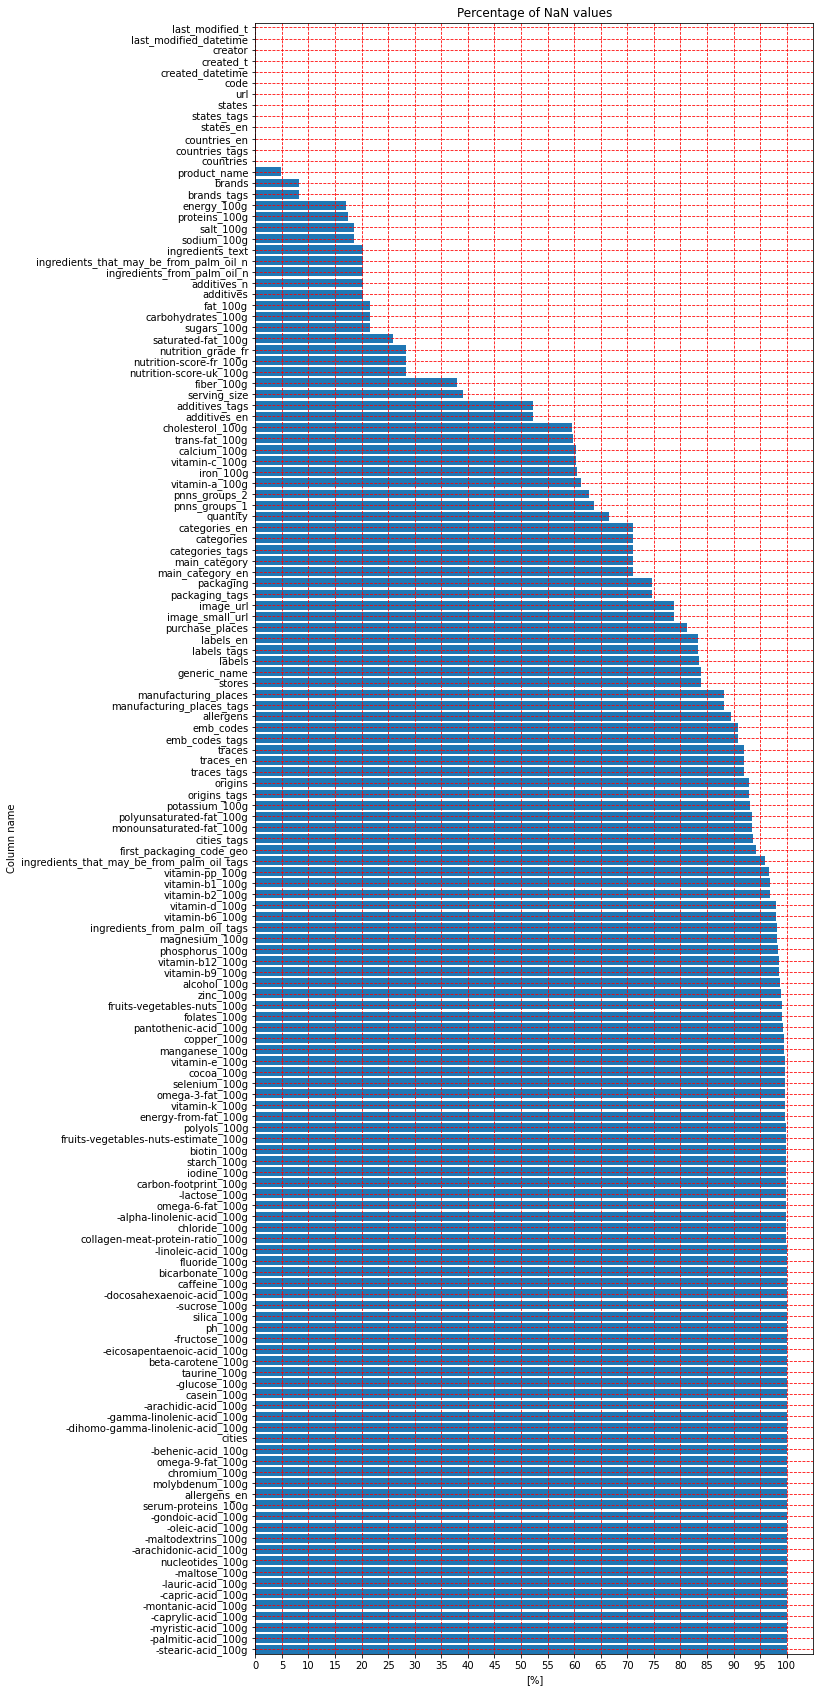

In [6]:
# Get from all columns the sum of NaN values and calculate the percentage of missing data and sort the values by descending order
nulls_sum = df.isnull().sum().apply(lambda x: (x*100/df.shape[0])).sort_values(ascending=False)

plt.figure(figsize=(10,30))
plt.title("Percentage of NaN values")
plt.xlabel("[%]")
plt.ylabel("Column name")
plt.xticks(np.arange(0,110,step=5))
plt.grid(zorder=0.99, color='r', linestyle='--') ## enable also the grid to be able to see the exact percentages of missing values
plt.margins(y=0)
plt.barh(nulls_sum.index, nulls_sum.to_numpy(),height=0.8) # in pandas., pydata.org they recommend to use to_numpy() instead of values
plt.show() 

***
From the above plot we can observe the following:
* about half of the columns with more than 95% missing entries are mostly numerical and these we can drop since columns with 5% of entries will not add value in this analysis as I will not go deeply looking for these nutritional facts.
* columns with more than 75% of missing values containing information about `manufacturing places, urls, allerges, products origins, city tags, packaging` etc I will also not use in the context of this analysis.

In the following I will `proceed by dropping the columns with more than 75% of missing entries by setting a threshold`. 
***

***
### **Drop columns with >=75% missing entries and check with how many columns we are left**
***

In [7]:
df_selected = df.dropna(axis=1, thresh = len(df)*0.25).copy()
df_selected.shape

(356027, 52)

***
### **Check again the info of the remaing 52 columns**
***

In [8]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 52 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     356001 non-null  object 
 1   url                                      356001 non-null  object 
 2   creator                                  356024 non-null  object 
 3   created_t                                356024 non-null  object 
 4   created_datetime                         356017 non-null  object 
 5   last_modified_t                          356027 non-null  object 
 6   last_modified_datetime                   356027 non-null  object 
 7   product_name                             338515 non-null  object 
 8   quantity                                 119285 non-null  object 
 9   packaging                                89959 non-null   object 
 10  packaging_tags                  

***
#### From now on,  the cleaning will be done in different steps according also to the tasks of the analysis and the number of NaN values per column that will be checked after each cleaning step.
***

***
### **Drop rows where there is missing information on the nutrition score**
***

In [9]:
df_selected.dropna(axis=0, subset=['nutrition_grade_fr','nutrition-score-fr_100g', 'nutrition-score-uk_100g'], inplace=True)# default is any (If any NA values are present, drop that row or column.)
df_selected.shape

(254856, 52)

In [10]:
df_selected.isnull().sum()

code                                            0
url                                             0
creator                                         1
created_t                                       0
created_datetime                                1
last_modified_t                                 0
last_modified_datetime                          0
product_name                                 2786
quantity                                   179762
packaging                                  190299
packaging_tags                             190299
brands                                       4887
brands_tags                                  4897
categories                                 179963
categories_tags                            179963
categories_en                              179963
countries                                      58
countries_tags                                 58
countries_en                                   58
ingredients_text                            24748


***
From the numerical columns we see that those that are always reported in the `Nutrional Facts` labels on the products:
   * `energy_100g`
   * `fat_100g` of which `saturated-fat_100g`
   * `carbohydrates_100g` of which `sugars_100g`
   * `proteins_100g`
   * `fiber_100g`
   * `salt_100g`
   
have still missing entries with the fibers having the most of them but only 16% of NaN values (41651/254856). So I will proceed by dropping rows with NaN values in these columns. 
***

***
### **Drop rows where the basic Nutrional Content is missing**
***

In [11]:
df_selected.dropna(axis=0, subset=['energy_100g',
                                   'fat_100g', 
                                   'saturated-fat_100g',
                                   'carbohydrates_100g',
                                   'sugars_100g',
                                   'fiber_100g',
                                   'proteins_100g',
                                   'salt_100g'], how='any', inplace=True)
df_selected.shape

(197160, 52)

In [12]:
df_selected.isnull().sum()

code                                            0
url                                             0
creator                                         0
created_t                                       0
created_datetime                                1
last_modified_t                                 0
last_modified_datetime                          0
product_name                                 2019
quantity                                   152906
packaging                                  158680
packaging_tags                             158680
brands                                       3752
brands_tags                                  3759
categories                                 153033
categories_tags                            153033
categories_en                              153033
countries                                      24
countries_tags                                 24
countries_en                                   24
ingredients_text                             6383


***
### **Drop rows if `ingredients_text, product_name, additives_n` or `countries` are missing since they are needed in the analysis:**

These columns have NaN values maximum 3% of the remaining number of entries
***

In [13]:
df_selected.dropna(axis=0, subset=['ingredients_text', 'additives_n', 'countries_tags', 'product_name'], inplace=True)
df_selected.shape

(189768, 52)

In [14]:
df_selected.isnull().sum()

code                                            0
url                                             0
creator                                         0
created_t                                       0
created_datetime                                1
last_modified_t                                 0
last_modified_datetime                          0
product_name                                    0
quantity                                   149575
packaging                                  153301
packaging_tags                             153301
brands                                       1577
brands_tags                                  1584
categories                                 148647
categories_tags                            148647
categories_en                              148647
countries                                       0
countries_tags                                  0
countries_en                                    0
ingredients_text                                0


***
From the numerical columns, those that have still missing values, they have in total about 30% of NaN's which is not negligible. I will first check their correlations before deciding to drop them or fill them with zeros.
***

***
### **Check the correlation of the numerical columns**

The `sns.pairplot` is very very slow. I found on stackoverflow another solution (taken from here:https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas) which is also very useful and can give a good intution. 
***

In [15]:
#sns.pairplot(df_selected, dropna=True)

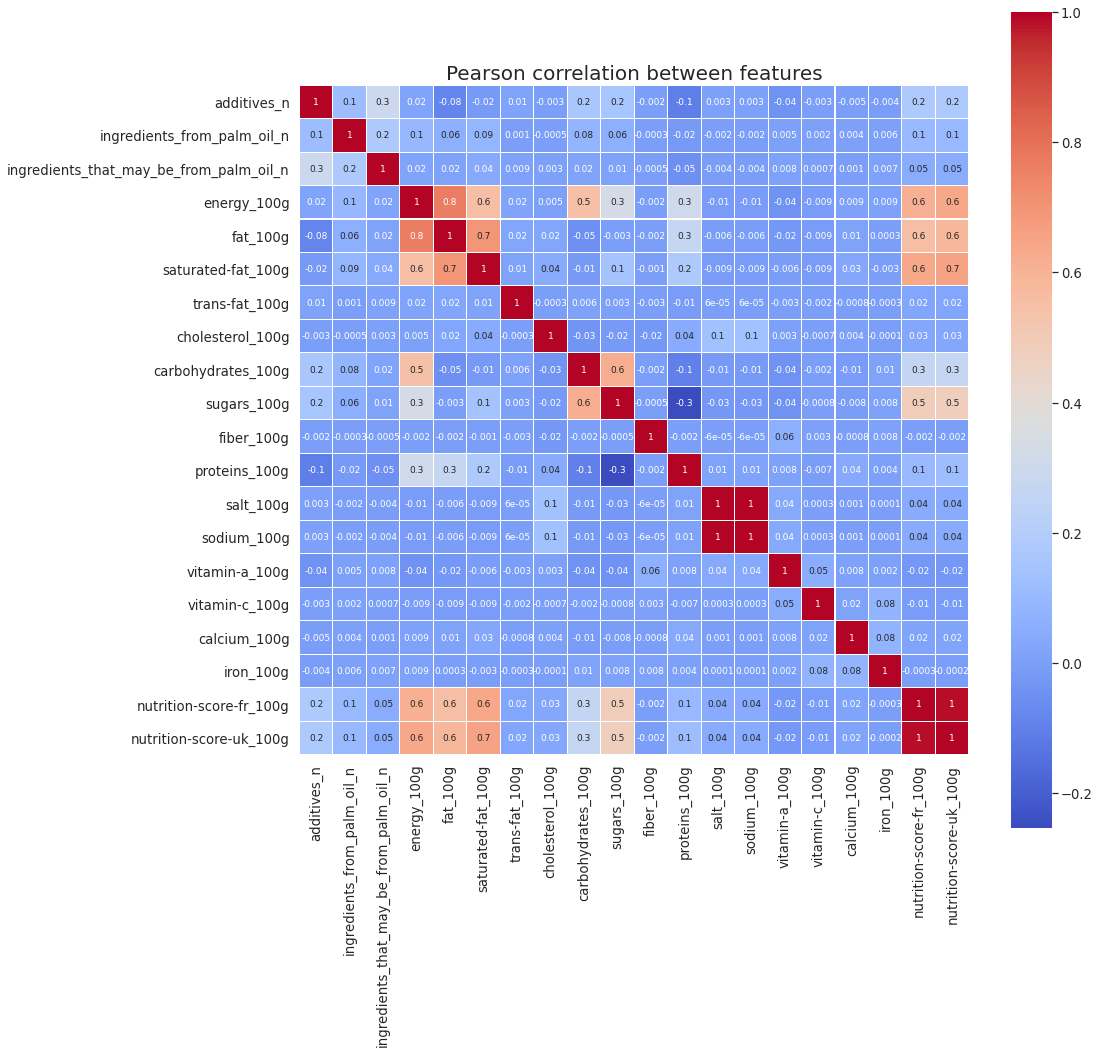

In [16]:
sns.set(font_scale=1.2)
corr = df_selected.corr()# Compute pairwise correlation of columns, excluding NA/null values, default=Pearson correlation
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr, 
                 xticklabels=True,
                 yticklabels=True,
                 square=True,
                 cmap='coolwarm',
                 linewidths=0.05,
                 annot=True, annot_kws={"size": 9}, fmt='.1g')
ax.set_title('Pearson correlation between features',fontsize= 20);
plt.show()

***
#### **Observations from the pearson correlation plot:**
   * First of all we see that the `nutrition scores` from `UK & France` and the `salt & sodium` columns `are highly correlated between each other`; Between the two nutrition scores we can see that there are some differences (for e.g. their correlarion with the saturated fats).
   * **`Nutrition Score`:** `is mostly positive correlated with calories (or energy), fats (including saturated fats) and carbohydrates but mostly sugars`. The number of additives, ingredients from palm oil and proteins have a small positive correlation but do not really seem to affect the nutrition score. The remaining nutritients like trans-fat, fibers, vitamins, calcium, iron do not really seem to be correlated with others so they will not add value to this analysis and we can drop them (those that have ~30% of NaNs)
   * **`Energy/calories`**, as it is known from the nutritional tables on products, `are calculated based on` several nutritionals but mostly from `fats (and the portion of saturated), carbohydrates (and the portion of sugars) and proteins`. Here we see this `positive correlation with those nutritions`.    
   * **`Carbohydrates and sugars`** `have a rather high positive correlation since some carbs consists of sugars.`
   * **`Number of additives`** seem to `have a rather small positive correlation with ingredients (that may be) from palm oil, sugars and carbohydrates and a rather small anticorrelation with proteins and fats`.  
   * **`Proteins`** `have a small positive correlation with fats and saturated fats and a small anticorrelation with carbs and sugars`
***

***
### **Drop the numerical columns with ~30% of missing values since they do not seem to add value in the context of this analysis and will not be further used.**
***

In [17]:
df_selected.drop(axis=1, columns=['iron_100g', 'calcium_100g', 'vitamin-c_100g', 'vitamin-a_100g', 'cholesterol_100g', 'trans-fat_100g'], inplace=True)
df_selected.shape

(189768, 46)

In [18]:
df_selected.isnull().sum()

code                                            0
url                                             0
creator                                         0
created_t                                       0
created_datetime                                1
last_modified_t                                 0
last_modified_datetime                          0
product_name                                    0
quantity                                   149575
packaging                                  153301
packaging_tags                             153301
brands                                       1577
brands_tags                                  1584
categories                                 148647
categories_tags                            148647
categories_en                              148647
countries                                       0
countries_tags                                  0
countries_en                                    0
ingredients_text                                0


***
### **Get the statistics of the numerical columns:**
***

In [19]:
df_selected.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,189768.000000,189768.000000,189768.000000,189768.000000,189768.000000,189768.000000,189768.000000,189768.000000,1.897680e+05,189768.000000,189768.000000,189768.000000,189768.000000,189768.00000
mean,1.915734,0.021147,0.054867,1182.286620,12.976564,4.600260,34.164901,14.817375,4.469600e+05,7.719064,1.351502,0.532087,8.671177,8.52776
std,2.526630,0.145658,0.267103,762.540763,15.830884,7.036546,28.186347,19.345116,1.947051e+08,8.095261,14.233041,5.603558,9.028259,9.10770
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.860000,0.000000e+00,-3.570000,0.000000,0.000000,-15.000000,-15.00000
25%,0.000000,0.000000,0.000000,448.000000,0.800000,0.000000,7.800000,1.430000,0.000000e+00,2.000000,0.100000,0.039370,1.000000,1.00000
50%,1.000000,0.000000,0.000000,1197.000000,6.900000,1.605000,25.840000,5.200000,1.600000e+00,5.620000,0.640000,0.251969,9.000000,9.00000
75%,3.000000,0.000000,0.000000,1733.000000,21.050000,6.670000,60.000000,23.000000,3.600000e+00,10.710000,1.323340,0.521000,16.000000,16.00000
max,30.000000,2.000000,6.000000,14644.000000,100.000000,100.000000,165.000000,145.000000,8.481815e+10,305.000000,3048.000000,1200.000000,40.000000,40.00000


***
### **Observations from statistics:**
   * the max value in the `energy_100g` column is ~10% higher than the 75 percantile. This is due to the fact that the energy was registered in different values (kjoules and kcal as mentioned here:https://static.openfoodfacts.org/data/data-fields.txt). We can `recalculate the energy` as mentioned here: https://courses.lumenlearning.com/cheminter/chapter/energy-in-food-and-nutrition/ by using:
     * `Fat = 9 kcal/g (Cal/g)`
     * `Carbohydrate = 4 kcal/g (Cal/g)`
     * `Protein = 4 kcal/g (Cal/g)`
   * for the nutritions that are quoted per 100 g, `the max value cannot really exceed 100 g` since they are grams per 100g. So we can remove these entries, as well as the `negative values` for `sugars and proteins`.
   * the `maximum` numbers in `additives, number of ingredients (that may be) from palm oil and the nutrition scores should not be taken into account as outliers`. The `nutrion score has a scale of -15 to 40` (https://www.santepubliquefrance.fr) and the number of additives or ingredients from palm oil can vary.
   * the `nutrition scores from UK and France have very similar statistics` as we saw also from the Pearson correlation plot.
***   

***
### **Clean the numerical columns that are quoted per 100g from negative values and max values that exceed 100g except the energy and the two nutrition scores:**
***

***
1. Get all the numeric columns of the dataframe except the `additives_n`, `ingredients_from_palm_oil_n`, `ingredients_that_may_be_from_palm_oil_n`, `energy_100g` and the two `nutrition-scores` in order to apply the cuts on the negative and max values.
***

In [20]:
col_numeric = list(df_selected.select_dtypes(np.number).columns)
print("All numerical columns from the selected dataframe:\n", col_numeric, "\n")

col_numeric = col_numeric[4:-2] 
print("Numerical columns selected with len:", len(col_numeric), '\n', col_numeric, '\n')

All numerical columns from the selected dataframe:
 ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'] 

Numerical columns selected with len: 8 
 ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'] 



***
2. Apply the cuts as mentioned above and check the remaining number of entries
***

In [21]:
print("Initial number of rows = ", df_selected.shape[0])

for col_name in col_numeric:
    df_selected = df_selected.loc[~((df_selected[col_name] < 0) | (df_selected[col_name] >100))].copy()
    
print("Number of rows after removing negative and max>100 values = ", df_selected.shape[0])

Initial number of rows =  189768
Number of rows after removing negative and max>100 values =  189701


***
### **Recalculate the energy per 100 g as mentioned above:**
***

In [22]:
df_selected['energy_100g_calculated'] = df_selected["fat_100g"]*9 + df_selected["carbohydrates_100g"]*4 + df_selected["proteins_100g"]*4

In [23]:
df_selected.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,energy_100g_calculated
count,189701.000000,189701.000000,189701.000000,189701.000000,189701.00000,189701.000000,189701.000000,189701.000000,189701.000000,189701.000000,189701.000000,189701.000000,189701.000000,189701.000000,189701.000000
mean,1.916036,0.021154,0.054871,1182.396811,12.97739,4.600129,34.166053,14.816386,2.874476,7.718480,1.219029,0.479933,8.669960,8.526492,284.334645
std,2.526507,0.145683,0.267122,762.425155,15.83015,7.033347,28.181934,19.339633,4.500925,8.066773,3.956046,1.557496,9.027947,9.107398,184.892912
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000,0.000000
25%,0.000000,0.000000,0.000000,448.000000,0.80000,0.000000,7.800000,1.430000,0.000000,2.000000,0.100000,0.039370,1.000000,1.000000,107.000000
50%,1.000000,0.000000,0.000000,1197.000000,6.90000,1.610000,25.840000,5.200000,1.600000,5.620000,0.640000,0.251969,9.000000,9.000000,290.000000
75%,3.000000,0.000000,0.000000,1733.000000,21.05000,6.670000,60.000000,23.000000,3.600000,10.710000,1.320800,0.520000,16.000000,16.000000,415.300000
max,30.000000,2.000000,6.000000,14644.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,39.370079,40.000000,40.000000,1433.360000


***
### **Drop initial energy:**
***

In [24]:
df_selected.drop(axis=1,columns=['energy_100g'],inplace=True)

***
### **Variable distribution of numerical columns:**

For each numeric column we can plot the distribution of the values in a `histogram` and the corresponding `box-plots` to see the quartiles of the data and the extension of the distribution. 

* For the histograms the `number of bins` is calculated using the `Sturge’s Rule`: 

$~~~~~~~~~~~~~n_{bins}= 1 + 3.322 \cdot log_{N}$, 

$~~~~~~$where $N$ is  the number of observations (in our case is the number of entries per column).
***

***
1. Get all the numeric columns of the dataframe
***

In [25]:
col_numeric = list(df_selected.select_dtypes(np.number).columns)

***
2. Define a function where in the 1st column the histogram will be plotted and in the 2nd one the box-plot
***

In [26]:
# define a function for the different plots in the 2 columns
def plot_columns(axrow, column_name, column):
    
    nbins = 1 + 3.322*np.log(column.count()) 

    axrow[0].hist(column, bins = int(nbins))
    axrow[0].set_yscale("log")
    axrow[0].set_title("{}".format(column_name))
    sns.despine(ax=axrow[0])
    
    sns.boxplot(x = column, ax=axrow[1], fliersize=2)
    axrow[1].set(yticks=[])
    sns.despine(ax=axrow[1], left=True)

***
3. Define a subplot with 2 columns and number of rows equals to the total number of numeric columns; call the above function to plot.
***

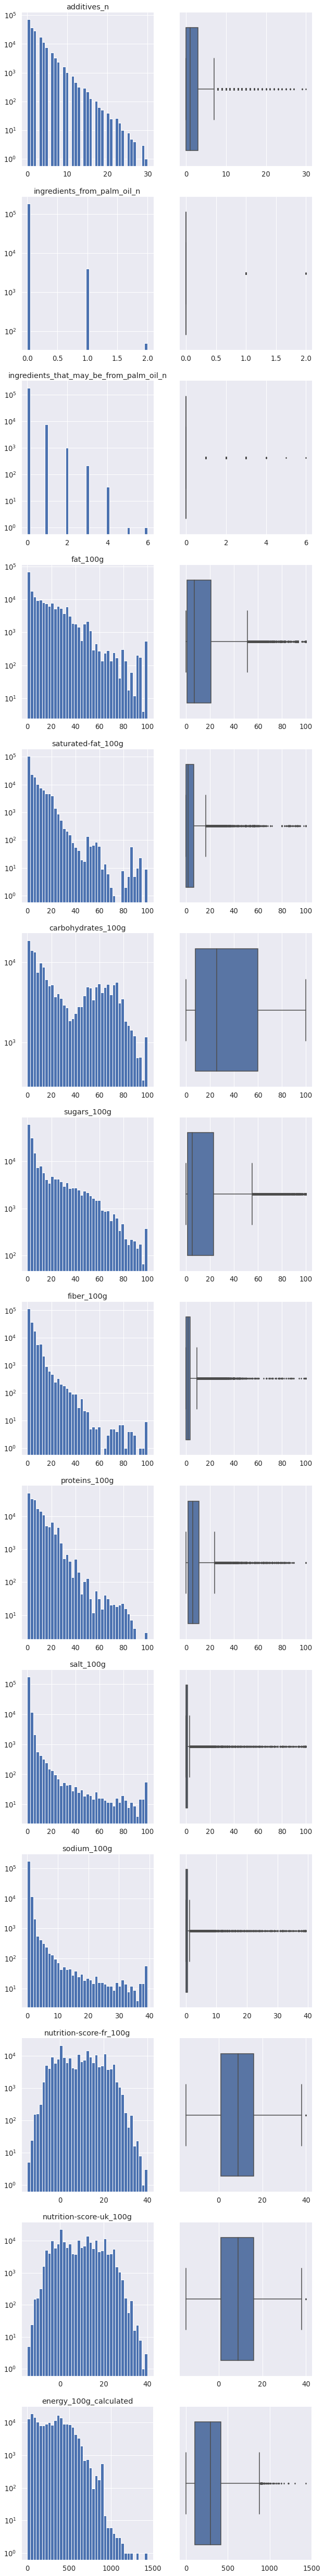

In [27]:
n_rows = len(col_numeric)
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols,  figsize=(10, 90))


for (row, num_of_row) in zip(axes, range(n_rows)):
    plot_columns(row, col_numeric[num_of_row], df_selected[col_numeric[num_of_row]])
        
for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

***
#### **Observations from histograms and boxplots:**
* after cleaning we see that all the histograms and the corresponding box-plots are reasonable 
* salt & sodium and two nutrition scores have very similar distributions
* there are also a lot of zeros for several columns that we have to check
***

***
### **Check the correlation between the nutritients that we saw in the Pearson's correlation plot**
***

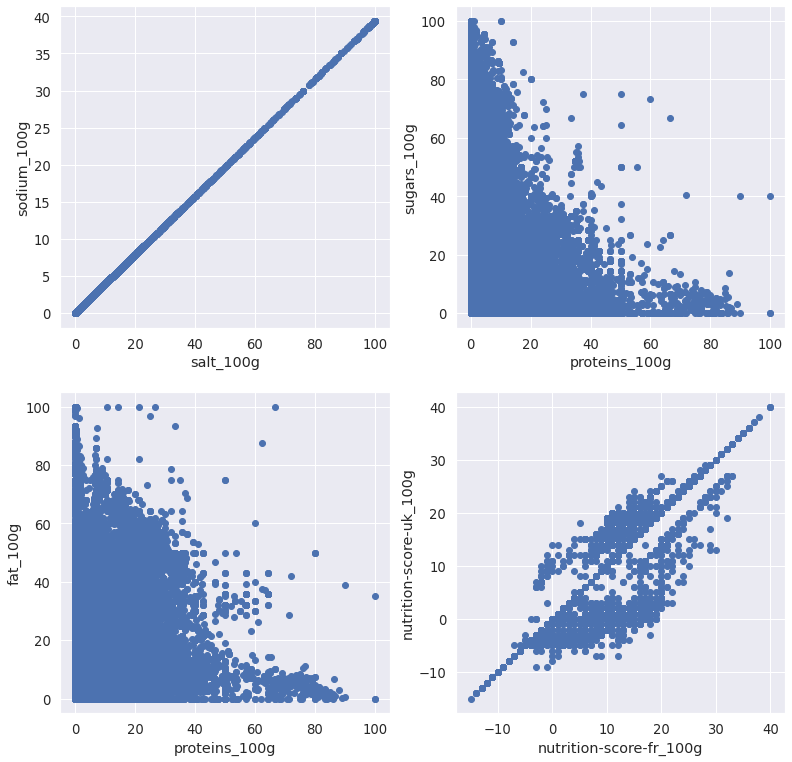

In [28]:
fig, axes = plt.subplots(2, 2,  figsize=(13, 13))

axes[0, 0].scatter(df_selected['salt_100g'], df_selected['sodium_100g'])
axes[0, 0].set_xlabel('salt_100g')
axes[0, 0].set_ylabel('sodium_100g')
#axes[0, 0].set_title('Salt vs Sodium')

axes[0, 1].scatter(df_selected['proteins_100g'], df_selected['sugars_100g'])
axes[0, 1].set_xlabel('proteins_100g')
axes[0, 1].set_ylabel('sugars_100g')
#axes[0, 1].set_title('Proteins vs sugars')

axes[1, 0].scatter(df_selected['proteins_100g'], df_selected['fat_100g'])
axes[1, 0].set_xlabel('proteins_100g')
axes[1, 0].set_ylabel('fat_100g')
#axes[1, 0].set_title('Proteins vs fats')

axes[1, 1].scatter(df_selected['nutrition-score-fr_100g'], df_selected['nutrition-score-uk_100g'])
axes[1, 1].set_xlabel('nutrition-score-fr_100g')
axes[1, 1].set_ylabel('nutrition-score-uk_100g')
#axes[1, 1].set_title('Nutrition score FR vs UK')

plt.show()

***
#### **Observations from the scatter plots:**
* For salt and sodium there is a perfect linear correlation
* Proteins with fats and sugars have some values which are unticorrelated
* The two nutrition scores have some entries which are linearly correlated but others not.  
***

***
### **Check the two nutrition scores together with the nutrition grade that is available only from France:**
***

In [29]:
df_selected[['nutrition_grade_fr','nutrition-score-fr_100g','nutrition-score-uk_100g']].groupby('nutrition_grade_fr').agg(lambda x: str(min(x))+"-"+str(max(x)))

,nutrition-score-fr_100g,nutrition-score-uk_100g
nutrition_grade_fr,,
a,-15.0-20.0,-15.0-12.0
b,-7.0-2.0,-9.0-14.0
c,2.0-10.0,-6.0-19.0
d,6.0-18.0,-7.0-24.0
e,10.0-40.0,-7.0-40.0


***
As we see the nutrition score from France does not have a continues range wrt the grading so is difficult to average the two scores and assign a new grade. For this reason, in the following, only the nutrition score and grade from France will be used whenever needed.
***

***
### **Have a look on some entries of the dataframe when the numerical columns per 100 g are all zeros.**
***

In [30]:
df_selected.loc[(df_selected['fat_100g']==0) &
                (df_selected['saturated-fat_100g']==0) &
                (df_selected['carbohydrates_100g']==0) &
                (df_selected['sugars_100g']==0) &
                (df_selected['fiber_100g']==0) &
                (df_selected['proteins_100g']==0) &
                (df_selected['salt_100g']==0) &
                (df_selected['energy_100g_calculated']==0)].tail(10)  #&
               # (df_selected['nutrition-score-fr_100g']==0) &
               # (df_selected['pnns_groups_1']=='unknown') &
               # (df_selected['pnns_groups_2']=='unknown') &
               # (df_selected['main_category'].isna())].tail(10)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,countries,countries_tags,countries_en,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,energy_100g_calculated
351042,8809071542578,http://world-en.openfoodfacts.org/product/8809...,usda-ndb-import,1489066698,2017-03-09T13:38:18Z,1489066698,2017-03-09T13:38:18Z,Roast Yerba Mate Tea,NaN,NaN,NaN,Creative Tea Comapany,creative-tea-comapany,NaN,NaN,NaN,US,en:united-states,United States,Yerba mate.,1.1 g (0.04 oz),0.0,[ yerba-mate -> en:yerba-mate ] [ mate -> e...,NaN,NaN,0.0,0.0,b,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351043,8809071542677,http://world-en.openfoodfacts.org/product/8809...,usda-ndb-import,1489066757,2017-03-09T13:39:17Z,1489066757,2017-03-09T13:39:17Z,"Creative Tea Company, Green Yerba Mate Tea, Green",NaN,NaN,NaN,Teazen Inc.,teazen-inc,NaN,NaN,NaN,US,en:united-states,United States,Yerba mate.,1.2 g (0.04 oz),0.0,[ yerba-mate -> en:yerba-mate ] [ mate -> e...,NaN,NaN,0.0,0.0,b,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351044,8809071549713,http://world-en.openfoodfacts.org/product/8809...,usda-ndb-import,1489066695,2017-03-09T13:38:15Z,1489066695,2017-03-09T13:38:15Z,"Creative Tea Company, Lemon Yerba Mate Tea, Lemon",NaN,NaN,NaN,Teazen Inc,teazen-inc,NaN,NaN,NaN,US,en:united-states,United States,"Yerba mate, lemon peels, fennel, roasted dande...",1.2 g (0.04 oz),0.0,[ yerba-mate -> en:yerba-mate ] [ mate -> e...,NaN,NaN,0.0,0.0,b,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351740,8853662003092,http://world-en.openfoodfacts.org/product/8853...,tacinte,1471277130,2016-08-15T16:05:30Z,1498921447,2017-07-01T15:04:07Z,Sauce pimentee sriracha,NaN,NaN,NaN,Exotic Food,exotic-food,NaN,NaN,NaN,"en:FR,France",en:france,France,"Piments (70%), Ail, Su' 'e(E415), Acidifiant (...",NaN,3.0,[ piments -> en:piments ] [ 70 -> en:70 ] ...,"en:e202,en:e330,en:e415","E202 - Potassium sorbate,E330 - Citric acid,E4...",0.0,0.0,b,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
352444,8938506854518,http://world-en.openfoodfacts.org/product/8938...,kiliweb,1497642617,2017-06-16T19:50:17Z,1497642623,2017-06-16T19:50:23Z,Thanh vinh,NaN,NaN,NaN,Organic,organic,NaN,NaN,NaN,France,en:france,France,sta mèt hb 2 1Èn g bén thvc phàm và thay thé t...,NaN,0.0,[ sta-met-hb-2-1en-g-ben-thvc-pham-va-thay-th...,NaN,NaN,0.0,0.0,b,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353212,90357725,http://world-en.openfoodfacts.org/product/9035...,openfoodfacts-contributors,1456400119,2016-02-25T11:35:19Z,1489488243,2017-03-14T10:44:03Z,Coca-cola zéro,200ml,NaN,NaN,Coca-Cola zero,coca-cola-zero,Sodas au cola light,"en:beverages,en:artificially-sweetened-beverag..."

***
We see that when we check if all all the nutritional facts quoted per 100g are zero they correspond to beverages like water, tea etc. But we see already here that other than foods or beverages we have also a `fairy tail` that is `registered on this dataset!` And we see also that there are duplicated product names. 
***

***
### **Check the NaN values again**
***

In [31]:
df_selected.isnull().sum()

code                                            0
url                                             0
creator                                         0
created_t                                       0
created_datetime                                1
last_modified_t                                 0
last_modified_datetime                          0
product_name                                    0
quantity                                   149516
packaging                                  153243
packaging_tags                             153243
brands                                       1576
brands_tags                                  1583
categories                                 148591
categories_tags                            148591
categories_en                              148591
countries                                       0
countries_tags                                  0
countries_en                                    0
ingredients_text                                0


***
### **Check the created_datetime entry with 1 NaN value**
***

In [32]:
nan_created_datetime = df_selected.loc[df_selected['created_datetime'].isnull()==True]
nan_created_datetime.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,countries,countries_tags,countries_en,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,energy_100g_calculated
192048,3017760038409,http://world-en.openfoodfacts.org/product/3017...,marianne,0,NaN,1488992055,2017-03-08T16:54:15Z,Lulu la barquette (Fraise),120 g,"Paquet,Carton","paquet,carton",LU,lu,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Bis...","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...","Sugary snacks,Biscuits and cakes,Biscuits,fr:B...","France,Suisse","en:france,en:switzerland","France,Switzerland","Sirop de glucose-fructose, purée de fraises 27...","Un biscuit (6,66g)",2.0,[ sirop-de-glucose-fructose -> fr:sirop-de-gl...,"en:e330,en:e440","E330 - Citric acid,E440 - Pectins",0.0,0.0,d,Sugary snacks,Biscuits and cakes,"en:to-be-checked, en:complete, en:nutrition-fa...","en:to-be-checked,en:complete,en:nutrition-fact...","To be checked,Complete,Nutrition facts complet...",en:sugary-snacks,Sugary snacks,2.1,0.5,78.0,60.0,1.2,4.2,0.08,0.031496,13.0,13.0,347.7


***
This is only 1 entry, but we can see that the corresponding unix timestamp is 0 so we cannot convert it to a datetime.
***

***
### **Drop the NaN value from the created_datetime column**
***

In [33]:
df_selected.dropna(axis=0, how='all', subset=['created_datetime'], inplace=True)

***
### **Check the most 10 frequent values of the categorical columns:**
***

In [34]:
# Get a list of the columns with dtype object
list_columns_objects = df_selected.select_dtypes(include=['object']).columns

# Check the 10 most frequent values 
for col in list_columns_objects:
    #print(col, '\n', df_selected[col].value_counts()[:10].index.tolist(), '\n')
    print(col, '\n', df_selected[col].value_counts()[:10].sort_values(ascending=False), '\n')


code 
 7622210397348    1
3257984410715    1
0093966005967    1
03003408397      1
5600798960132    1
0078742065915    1
3329770044586    1
7610849690534    1
0071187101224    1
0070970547546    1
Name: code, dtype: int64 

url 
 http://world-en.openfoodfacts.org/product/0078742038513/oatmeal-raisin-cookies-price-first                      1
http://world-en.openfoodfacts.org/product/0688267160028/chipotle-lime-finishing-butter-ahold                    1
http://world-en.openfoodfacts.org/product/0072273449442/baked-beans-seasoned-with-smoked-pork-kc-masterpiece    1
http://world-en.openfoodfacts.org/product/3270160297429/poulet-a-la-basquaise-et-riz-picard                     1
http://world-en.openfoodfacts.org/product/8023678423225/cuisine-epeautre-isola-bio                              1
http://world-en.openfoodfacts.org/product/0010995305639/12-mini-gold-cupcakes-maplehurst-bakeries-llc           1
http://world-en.openfoodfacts.org/product/0024300041334/strawberry-shortcake-rolls-lit

***
From the categorical columns we see that:
* some are not needed at all in the context of this analysis and can be dropped
* there are several columns with the same content line for e.g. categories_tags, main category, pnn groups, countries etc
* most of the products registered in this dataset are sold in United States
* most of the products are registered by "usda-ndb-import"
***

***
### **Drop categorical columns that are not needed in the context of this analysis**
***

In [35]:
columns_to_remove = ['url',
                     'categories',
                     'categories_en',
                     'main_category_en',
                     'additives_en',
                     'additives',
                     'quantity',
                     'packaging',
                     'packaging_tags',
                     'brands',
                     'brands_tags',
                     'countries',
                     'countries_en',
                     'serving_size',
                     'states',
                     'states_tags',
                     'states_en']

# drop columns that are not needed
df_selected.drop(axis=1,columns=columns_to_remove, inplace=True)
print('#Columns left = ',len(df_selected.columns))

#Columns left =  29


In [36]:
df_selected.isnull().sum()

code                                            0
creator                                         0
created_t                                       0
created_datetime                                0
last_modified_t                                 0
last_modified_datetime                          0
product_name                                    0
categories_tags                            148591
countries_tags                                  0
ingredients_text                                0
additives_n                                     0
additives_tags                              71515
ingredients_from_palm_oil_n                     0
ingredients_that_may_be_from_palm_oil_n         0
nutrition_grade_fr                              0
pnns_groups_1                              135715
pnns_groups_2                              135689
main_category                              148591
fat_100g                                        0
saturated-fat_100g                              0


***
### **Check few entries that are not registered by usda-ndb-import**
***

In [37]:
df_selected.loc[df_selected['creator']!='usda-ndb-import'].tail(8)

,code,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,categories_tags,countries_tags,ingredients_text,additives_n,additives_tags,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,energy_100g_calculated
355922,96118580,sebleouf,1482390133,2016-12-22T07:02:13Z,1482594570,2016-12-24T15:49:30Z,Fisherman's Friend Miel-Citron,"en:sugary-snacks,en:confectioneries,en:candies...",en:france,"Édulcorants : sorbitols, sucralose, acésulfame...",5.0,"en:e330,en:e420,en:e572,en:e950,en:e955",0.0,1.0,b,Sugary snacks,Sweets,en:sugary-snacks,1.3,1.28,95.31,0.1,1.47,0.004,0.001,0.000394,2.0,2.0,392.956
355970,9782012006973,kiliweb,1499810845,2017-07-11T22:07:25Z,1499810850,2017-07-11T22:07:30Z,"Stormbreaker, Anthony Horowitz",NaN,en:france,Ingredientes: mezcla de proteinas vcgetales (p...,0.0,NaN,0.0,0.0,c,unknown,unknown,NaN,6.5,2.80,0.00,0.0,5.50,30.000,1.300,0.511811,6.0,6.0,178.500
355971,9782091778181,kiliweb,1496600202,2017-06-04T18:16:42Z,1496600206,2017-06-04T18:16:46Z,La pratique du vocabulaire allemand,NaN,en:france,I • La grammajre françatse La communication or...,0.0,NaN,0.0,0.0,e,unknown,unknown,NaN,25.0,15.00,54.00,53.0,2.00,5.000,12.000,4.724409,28.0,28.0,461.000
355974,9782226399311,kiliweb,1505392509,2017-09-14T12:35:09Z,1505392514,2017-09-14T12:35:14Z,Treize Raisons,"en:dairies,en:milks",en:france,"(J'espère que vous êtes prêts, parce que je va...",0.0,NaN,0.0,0.0,d,Milk and dairy products,Milk and yogurt,en:dairies,5.0,4.00,58.00,38.0,55.00,2.000,80.000,31.496063,16.0,16.0,285.000
355977,9782745932792,kiliweb,1504285120,2017-09-01T16:58:40Z,1504285128,2017-09-01T16:58:48Z,Ma bite,"en:beverages,en:non-sugared-beverages",en:france,Du sperme de la viande du viagra,0.0,NaN,0.0,0.0,b,Beverages,Non-sugared beverages,en:beverages,1.0,1.00,1.00,1.0,10.00,10.000,1.000,0.393701,-2.0,-6.0,53.000
355979,9782811613488,kiliweb,1503745692,2017-08-26T11:08:12Z,1503745703,2017-08-26T11:08:23Z,Fairy tail,NaN,en:france,Le deuxième jour du Grand Tournoi de la magie ...,0.0,NaN,0.0,0.0,d,unknown,unknown,NaN,12.0,12.00,12.00,12.0,12.00,12.000,12.000,4.724409,17.0,17.0,204.000
355980,9782811635848,kiliweb,1499617591,2017-07-09T16:26:31Z,1499617638,2017-07-09T16:27:18Z,Fairy Tail,NaN,en:france,"Eileen a fait usage d'Univers 0ne, un sort de ...",0.0,NaN,0.0,0.0,b,unknown,unknown,NaN,0.0,0.00,0.00,0.0,0.00,0.000,0.000,0.000000,0.0,0.0,0.000
355981,9782816154160,kiliweb,1500917476,2017-07-24T17:31:16Z,1500917479,2017-07-24T17:31:19Z,"Biscuits aux céréales, aux pépites de chocolat...",NaN,en:france,"céréales* 49% (farine de blé*, flocons b d'avo...",2.0,"en:e322,en:e503",0.0,0.0,d,unknown,unknown,NaN,22.0,9.00,60.00,27.0,5.00,8.000,0.280,0.110236,14.0,14.0,470.000


***
`We see here some additional books: fairy tails and vocabularies!` and most probably there should be other irrelevant entries!
* one common thing that they have is that their `pnn groups` are `uknown` so we can probably use this flag to drop this kind of rows from the dataset. We already know that these are 17965 entries as we saw before when we listed the top 10 most frequent values from the categorical columns; but this we have to check. 
* the vocabulary unfortunately has quite different numerical values in the correspoing per 100g columns
* the one fairy tail has 0 values in the corresponding per 100g columns but the other one has some values that are not zero
* the other common thing that they have is that the categories_tags and the main_category is also NaN
***

***
Try to see if with the combination mentioned above we can catch other entries in the dataset not related to food
***

In [38]:
#pd.set_option('max_rows',6751)
#pd.set_option('display.max_colwidth',300)
df_selected[['code','product_name','ingredients_text']][(df_selected['pnns_groups_1']=='unknown') & 
                (df_selected['pnns_groups_2']=='unknown') &
                 (df_selected['categories_tags'].isna()) &                                                             
                (df_selected['additives_tags'].isna()) &
                (df_selected['main_category'].isna())]

,code,product_name,ingredients_text
600,00033909,Victoria plum and bergamot yogurt,victoria plum & bergamot yogurt 00033909 desse...
657,00052368,Belgian milk chocolate coated brazil nuts,Brazil nuts INGREDlENTs Dried Whole Milk Cocoa...
665,00057998,Thai green chicken soup,"Water, Long Grain Rice (13%) ? Onions?coàl? Ch..."
712,00072878,Laksa noodle pot,NOODLE POT EAbY IN 2 MINUTES for a delicioug z...
737,00078832,BERRY MEDLEY,"raisins, fraisest framboises, mures et myrtill..."
...,...,...,...
355912,96087770,Peanut & Popcorn With Dark Chocolate 12 x 45G,Eat Natural — Barres aux fruits secs avec caca...
355970,9782012006973,"Stormbreaker, Anthony Horowitz",Ingredientes: mezcla de proteinas vcgetales (p...
355971,9782091778181,La pratique du vocabulaire allemand,I • La grammajre françatse La communication or...
355979,9782811613488,Fairy tail,Le deuxième jour du Grand Tournoi de la magie ...


***
Unfortunately this combination catches also entries which are indeed foods but checking a bit by eye on this list, other than books there are also some mobile devices, cream faces etc. Since is impossible to go through ~6800 and since these are only 3% of the data which in any case they have unknown categories and will be dropped in Task B, I will proceed by dropping all of them.  
***

***
1. Get the shape of the dataframe
***

In [39]:
df_selected.shape

(189700, 29)

***
2. Create a new dataframe with the above combination to drop it
***

In [40]:
df_to_drop = df_selected[(df_selected['pnns_groups_1']=='unknown') & 
                (df_selected['pnns_groups_2']=='unknown') &
                 (df_selected['categories_tags'].isna()) &                                                             
                (df_selected['additives_tags'].isna()) &
                (df_selected['main_category'].isna())]
df_to_drop.shape

(6755, 29)

***
3. Drop the above dataframe from the existing one; The succesfull operation can be checked by the number of rows which must be 182945
***

In [41]:
df_selected = df_selected[~df_selected.index.isin(df_to_drop.index)]
df_selected.shape

(182945, 29)

***
### **Check for duplicated values in the code and product_name columns**
***

In [42]:
print('duplicate_codes = ', df_selected.duplicated(['code']).sum())
print('duplicate_products = ', df_selected.duplicated(['product_name']).sum())

duplicate_codes =  0
duplicate_products =  49950


***
The duplicated products are ~27% without performing any text correction and without checking them in combination with other columns.
***

***
### **Have a look on few duplicated products**
***

In [43]:
pd.set_option('display.max_colwidth',300)
duplicate_products = df_selected[df_selected.duplicated(['product_name'], keep='last')]
duplicate_products[['product_name','ingredients_text','countries_tags','additives_n','additives_tags','energy_100g_calculated','nutrition-score-fr_100g','main_category','pnns_groups_1', 'pnns_groups_2']].tail(11)

,product_name,ingredients_text,countries_tags,additives_n,additives_tags,energy_100g_calculated,nutrition-score-fr_100g,main_category,pnns_groups_1,pnns_groups_2
354142,Vegemite,"Yeast extract (from yeast grown on _barley_ and _wheat_), salt, mineral salt (E508), malt extract (from _barley_), colour (E150C), flavours, niacin, thiamine, riboflavin, folate.",en:australia,4.0,"en:e101,en:e101i,en:e150c,en:e375,en:e508",190.20,7.0,en:plant-based-foods-and-beverages,unknown,unknown
354143,Vegemite,"Yeast Extract (from Yeast grown on Barley), Salt, Mineral Salt (508), Malt Extract (from Barley), Colour (150c), Flavours, Niacin, Thiamine, Riboflavin, Folate.",en:australia,2.0,"en:e101,en:e101i,en:e375",182.10,7.0,en:spreads,unknown,unknown
354154,Vegemite,"yeast extract (from yeast grown on _barley_ and _wheat_), salt, malt extract (from _barley_), flavour enhancer (potassium chloride), colour (E150c), spice extract (contains _celery_), niacin, thiamin, riboflavin, folic acid",en:france,4.0,"en:e101,en:e101i,en:e150c,en:e375,en:e508",186.30,12.0,en:spreads,unknown,unknown
354224,Coke Zero,"Carbonated Purified Water, Colour (Caramel E150d), Food Acids (E338, E331), Flavour, Sweeteners (E951, E950), Preservative (E211), Caffeine.",en:australia,6.0,"en:e150d,en:e211,en:e331,en:e338,en:e950,en:e951",0.60,1.0,en:beverages,Beverages,Non-sugared beverages
354408,Coco pops,"Whole white rice (59%), sugar, cocoa (3%), calcium carbonate, iron, zinc oxide, salt, dextrose, _barley_ malt extract, vitamin C, niacin, thiamin, riboflavin, folate",en:australia,3.0,"en:e101,en:e101i,en:e170,en:e375",375.60,16.0,en:plant-based-foods-and-beverages,Cereals and potatoes,Cereals
354601,Sauce soja,"Water, Defatted Soybean (27%), Wheat Sugar, Flavour Enhancers (E621 , E631). Contains 3.9ml/1 OOml alcohol which will reduce Ingrédients: Eau, Soja Dégraissé (27%), Blé, Sel, Sucre, exhausteur de goût (E621, E631). Contient 3.9ml/1 OOml d'alcool qui se réduira Zutaten: Wasser, Entfette Sojabohne...",en:france,2.0,"en:e621,en:e631",194.80,12.0,NaN,unknown,unknown
355358,Greek Nonfat Yogurt,"Cultured pasteurized grade a nonfat milk, sugar, blueberries, corn starch, blackberry puree, raspberry puree, natural flavor, fruit juice concentrate (for color), lemon juice concentrate, contains l. bulgaricus, streptococcus thermophilus, l. acidophilus,",en:united-states,0.0,NaN,74.68,-4.0,NaN,NaN,NaN
355359,Greek Nonfat Yogurt,"Cultured pasteurized grade a nonfat milk, sugar, corn starch, passion fruit juice concentrate natural flavor. contains l. bulgaricus, streptococcus thermophilus, l. acidophilus, bifidus, and l. casei live & active cultures.",en:united-states,0.0,NaN,74.68,-4.0,NaN,NaN,NaN
355360,Greek Nonfat Yogurt,"Cultured pasteurized grade a nonfat milk, sugar, concord grape puree, corn starch natural flavor, fruit and vegetable juice concentrate (for color). contains l. bulgaricus, streptococcus thermophilus, l. acidophilus, bifidus, and l. casei live & active cu",en:united-states,0.0,NaN,80.00,-3.0,NaN,NaN,NaN
355364,Blended Nonfat Yogurt,"Cultured pasteurized grade a nonfat milk, sugar, modified corn starch, passion fruit juice concentrate fructose, milk protein concentrate, kosher gelatin, natural flavors, gellan gum, vitamin a palmitate, vitamin d 3. contains l. acidophilus, bifidus, and",en:united-states,2.0,"en:e418,en:e428",65.88,1.0,NaN,NaN,NaN


***
From these few entries we can see the following:
* If we take for e.g. the first 3 entries for the product `Vegemite` we see that the ingredients are the same except the folate (first two) vs the folic acid (last one). From a quick search I found that the folate is the natural form of vitamin B9 in food, while folic acid is a synthetic form. So the nutrition score is correct worse for the product having the folic acid. `So to look for duplicated products, the nutrition_score in combination with the product_name would work properly`. We see also that the 2nd entry has a wrong number of additives and wrong additive_tags list because the E508 and the E150C which are missing they exist in the ingredients text. And in all 3 cases the energy is different, as well as the main category. So at least in this example it seems that the product name in combination with the number of additives or the energy will not work properly. Instead the product name in combination with the countries_tag and the nutrition score would work. 
* If we see the 3 entries for the `Greek Nonfat Yogurt` which is sold in US, the first two have the same energy but all the three looks to have different fruit juice or fruit puree from the ingredients text. In this case the number of additives is the same and `if we would combine the product_name with the countries_tag and the nutrition score we can find the duplicated product names`. 
* For the `Blended Nonfat Yogurt` sold in US, the number of additives, addtive_tags and the nutrition score are the same. The energy is different and the ingredients text even if the indredients are not listed in the same order they are also the same. So again here it looks that `the combination of the product_name together with the countries_tags and the nutrition score would work ok`. 

**So before using this combinations to find `duplicated products` we have to do some text normalization and correction on the `product_name`.**

One more thing that is worth to mention also here is that the number or additives is not always consistent wrt the number of elements in the additive tags. But if we look on the products which have the Riboflavin (E101) additive and after checking the list of additives here: https://world.openfoodfacts.org/additives we see that indeed, E101 is the "family" name of the additive and it has two different types of compounds, the E101i and the E101ii. Thus is correct that E100 and E101i should not be double counted. 
***

***
### **Text normalization/correction on the product_name**
***

In [44]:
df_selected['product_name'] = df_selected['product_name'].str.lower().copy() # make all letters small
df_selected['product_name'] = df_selected['product_name'].str.strip().copy() # strip out empty spaces

In [45]:
#df_selected['product_name'][df_selected['product_name'].str.contains(re.compile('[\W]$'))].to_list()

In [46]:
df_selected['product_name'] = df_selected['product_name'].replace('[\W]$','', regex=True).copy() # remove from the end of the string metacharacters

In [47]:
df_selected['product_name'][df_selected['product_name'].str.contains(re.compile('^[\W]'))].to_list()

["'prodhead'&gt;sriracha chilli sauce",
 '@ ease, lean stuffed sandwiches, pepperoni pizza',
 '@ ease, ham & cheese stuffed sandwiches',
 '@ ease, long grain white rice side dish',
 '@ ease, bacon cheeseburger sandwich',
 '@ ease, breaded chicken sandwich',
 '@ ease, cheeseburger sandwich',
 '@ ease, sweet corn with butter sauce',
 '@ease, broccoli',
 '@ease, broccoli, cauliflower & carrot with cheese sauce',
 '@ease, fire-roasted corn with butter sauce',
 '@ ease, asian blend seasoned vegetables',
 '@ ease, pound cake, blueberry',
 '@ ease, oatmeal bowl, apple, cranberry',
 '@ ease, oatmeal bowl, brown sugar',
 '@ ease, lasagna with meat sauce',
 '# 15 buffalo chicken buffalo style chicken & mozzarella cheese in a soft white wrap',
 '(barcode clash) houmous with extra virgin olive oil et yaourt',
 '`gravenstein apple juice',
 '(ground shrimp',
 '!, halloween mix whole wheat cookies',
 '!, wheat cookies',
 '!holla nolla!, bon temps!, real restaurant tortilla chips',
 '!, gummie flower'

In [48]:
df_selected['product_name'] = df_selected['product_name'].str.replace('&gt;','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('15 buffalo chicken','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('holla nolla!, bon temps!, real restaurant','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('&quot;no name&quot;-','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('&quot;00&quot;','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('&quot;fi&quot;,','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('&quot;','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('(35)','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('x90','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('(1-35)','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('(87)','').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace('al dente 11 mn','').copy()

In [49]:
df_selected['product_name'] = df_selected['product_name'].replace('^[\W*]','', regex=True).copy()# remove from the begining of the string metacharacters

In [50]:
df_selected['product_name'] = df_selected['product_name'].str.strip().copy() # strip out empty spaces

In [51]:
df_selected['product_name'] = df_selected['product_name'].replace('^[\W*]','', regex=True).copy()# remove from the begining of the string metacharacters

In [52]:
df_selected['product_name'] = df_selected['product_name'].str.strip().copy() # strip out empty spaces

In [53]:
# check the list again
#df_selected['product_name'][df_selected['product_name'].str.contains(re.compile('^[\W]'))].to_list()

In [54]:
df_selected['product_name'] = df_selected['product_name'].replace('[\&]','and', regex=True).copy() # replace the symbol & by the word "and"

In [55]:
df_selected['product_name'] = df_selected['product_name'].replace('[\,)]','', regex=True).copy() 
df_selected['product_name'] = df_selected['product_name'].str.replace("the",'').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace("comapny",'company').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace("confection",'confectionery').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace("congections",'confectionery').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace("collections",'confectionery').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace("conefections",'confectionery').copy()
df_selected['product_name'] = df_selected['product_name'].str.replace("pb and j",'pbandj').copy()
df_selected['product_name'] = df_selected['product_name'].replace('[\+]','', regex=True).copy()
df_selected['product_name'] = df_selected['product_name'].replace('[\(]','', regex=True).copy() 
df_selected['product_name'] = df_selected['product_name'].replace('[\)]','', regex=True).copy() 
df_selected['product_name'] = df_selected['product_name'].str.strip().copy() 

In [56]:
df_selected['product_name'] = df_selected['product_name'].replace(r'(\s\'\D)','', regex=True).copy() 

In [57]:
df_selected['product_name'] = df_selected['product_name'].replace('[\s+]','_', regex=True).copy() 

In [58]:
# check the list
#df_selected['product_name'][df_selected['product_name'].str.contains(re.compile('[\S]'))].to_list()

***
#### **Drop duplicated `product_name` in combination with `nutrition-score-fr_100g` and `countries_tags`**
***

In [59]:
print('duplicate_products = ', df_selected.duplicated(['product_name','nutrition-score-fr_100g','countries_tags']).sum())

duplicate_products =  32194


In [60]:
df_selected.shape

(182945, 29)

In [61]:
df_selected = df_selected.drop_duplicates(subset=['product_name','nutrition-score-fr_100g','countries_tags'], keep='first').copy()
df_selected.shape

(150751, 29)

***
### **Perform also some text normalization on the `ingredients_text` column**
***

In [62]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.lower().copy() # make all letters small
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.strip().copy() # strip out empty spaces

In [63]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].replace('[\W]$','', regex=True).copy() # match any match any metacharacter in the end 

In [64]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].replace('^[\W+]','', regex=True).copy() # match any match any metacharacter in the start 

In [65]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.strip().copy() # strip out empty spaces

In [66]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].replace('^[\W+]','', regex=True).copy() # match any match any metacharacter in the end 

In [67]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.strip().copy() # strip out empty spaces

In [68]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].replace('^[\W+]','', regex=True).copy() # match any match any metacharacter in the end 

In [69]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.strip().copy() # strip out empty spaces

In [70]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.replace('[\*\.\•\;]','', regex=True).replace('\s:\s',':', regex=True)
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.replace('[\.]$','', regex=True).replace(r'[\b_\b]','', regex=True)

In [71]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].replace('^[\W+]','', regex=True).copy() # match any match any metacharacter in the end 

In [72]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.strip().copy() # strip out empty spaces

In [73]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].replace('^[\W+]','', regex=True).copy() # match any match any metacharacter in the end 

In [74]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.strip().copy() # strip out empty spaces

In [75]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].replace('^[\W+]','', regex=True).copy() # match any match any metacharacter in the end 

In [76]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.strip().copy() # strip out empty spaces

In [77]:
# check
#df_selected['ingredients_text'][df_selected['ingredients_text'].str.contains(re.compile('^[\W]'))].to_list()

In [78]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.replace('\s-\s','-', regex=True)

In [79]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.replace('\s-','-', regex=True)

In [80]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.replace('(\s)(?=%)','', regex=True) # remove white space that is found only before the special character %

In [81]:
df_selected['ingredients_text'] = df_selected['ingredients_text'].str.replace('\s\%\s','', regex=True) # remove ch. % between spaces that is not attached to digit

In [82]:
# check
# df_selected['ingredients_text'][df_selected['ingredients_text'].str.contains(re.compile('[\W]'))].to_list()

***
### **Check again the NaN values of all columns**
***

In [83]:
df_selected.shape

(150751, 29)

In [84]:
df_selected.isnull().sum()

code                                            0
creator                                         0
created_t                                       0
created_datetime                                0
last_modified_t                                 0
last_modified_datetime                          0
product_name                                    0
categories_tags                            113671
countries_tags                                  0
ingredients_text                                0
additives_n                                     0
additives_tags                              52037
ingredients_from_palm_oil_n                     0
ingredients_that_may_be_from_palm_oil_n         0
nutrition_grade_fr                              0
pnns_groups_1                              107786
pnns_groups_2                              107760
main_category                              113671
fat_100g                                        0
saturated-fat_100g                              0


***
#### Since the remaining NaN values are max 75% of the entries I will stop the cleaning here and when it is neccessary to use information from the categorical columns I will create different dataframes by selecting the non NaN values
***

***
# <span style="color:blue">**Task B: In depth analysis**</span>
***

***
### **1. Are the number of additives correlated with the nutrition score?**
***

***
The nutrition score is graded as shown in the picture below. Grade "A" corresponds to -15 on the score which is the best grading, while grade "E" corresponds to very bad nutritians and high positive scores up to 40.
***

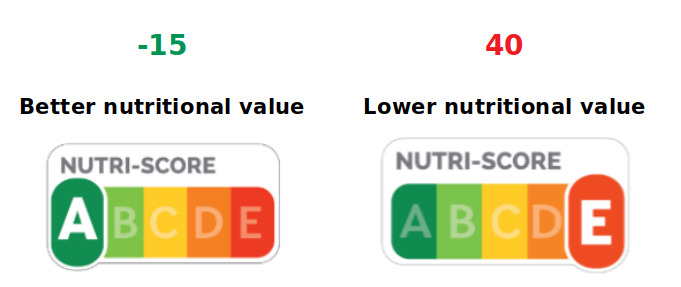

In [85]:
from IPython.display import Image
Image(filename='nutrional_grade.png')

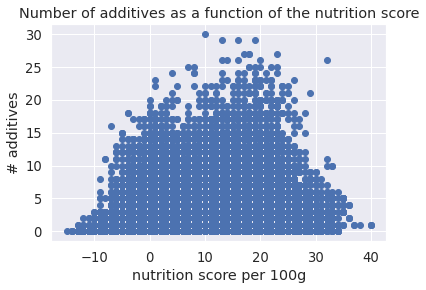

In [86]:
plt.scatter(df_selected['nutrition-score-fr_100g'], df_selected['additives_n'])
plt.xlabel('nutrition score per 100g')
plt.ylabel('# additives')
plt.title('Number of additives as a function of the nutrition score')

plt.show()

***
As we see from the above plot, the number of additives is not correlated with the nutririon score. There are few number of additives on both A and E nutri-scores and for the intermediate scores the number of additives can be either very low or very high. This is also in agreement with the Pearson correlation plot that we saw earlier where the correlation between those two values was quite low at 0.2. We can also see the same if we plot the number of entries (or rows) of the additives as a function of the nutrition grade (see plot below). We see that there is no real correlation between those two values.
***

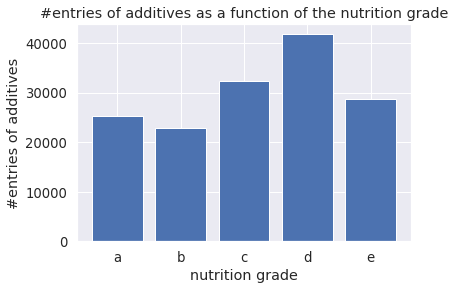

In [87]:
df_additives = df_selected.groupby('nutrition_grade_fr')['additives_n'].count().to_frame()

x_cor = np.arange(5)
plt.bar(x_cor, df_additives['additives_n'])
plt.xticks(x_cor, df_additives.index);
plt.xlabel('nutrition grade')
plt.ylabel('#entries of additives')
plt.title('#entries of additives as a function of the nutrition grade')
plt.show()

***
### **2. How the products are classified according to their risk?**
***

***
To answer this question, I will fist create 3 risk_additive lists which will correspond to low, moderate and high risk additives as mentioned here: https://world.openfoodfacts.org/additives and then, since some products can have more than one additives, I will classify each entry as following:

* if there is at least 1 high risk additive per entry the whole list will be flagged as`high`
* if there is at least 1 moderate risk additive the flag will be`moderate`
* if there is at least 1 low or no risk additive the flag will be`low`
* if the additives are not found in the corresponding 3 risk_additive lists they will be flagged as `unknown`

A new column called `additives_tags_classification` will be created in our dataframe that will hold these flags.
***

***
1. Create the 3 `risk_additive` lists manually
***

In [88]:
# Lists for the risk of additives taken from here: https://world.openfoodfacts.org/additives 
high_risk_additives=['e202', 'e407', 'e450', 'e250', 'e341', 'e211', 'e621', 'e200', 'e452', 'e481', 'e340', 'e223', 'e451', 'e338', 'e220', 'e252', 'e339', 'e212', 'e224', 'e491', 'e222', 'e251', 'e407a', 'e492', 'e221', 'e473', 'e210', 'e343', 'e482', 'e228', 'e155', 'e243', 'e226', 'e494', 'e459', 'e493', 'e213']
moderate_risk_additives=['e150c', 'e133', 'e435', 'e433', 'e960', 'e509', 'e131', 'e508', 'e142', 'e511', 'e432', 'e436', 'e507', 'e434']
low_risk_additives=['e129', 'e316', 'e951', 'e132', 'e150a', 'e1520', 'e150d', 'e170i', 'e315', 'e150b', 'e122', 'e151', 'e123']

***
2. Define a function which takes as input the `additives_tags` per entry as a list and checks each additive separate. The assignment of the flag is as mentioned above
***

In [89]:
# Define a function where we can check the additives in the dataframe and assign the risk
import operator

def check_risk(additive_tag):
    
    dict_risk={
        'high_risk_additives': 0,
        'moderate_risk_additives': 0, 
        'no_or_very_low_risk_additives': 0,
        'unknown': 0
    }

    for tag in additive_tag:
        for high in high_risk_additives:
            if tag==high:
                dict_risk['high_risk_additives'] += 1
                
        for moderate in moderate_risk_additives:
            if tag==moderate:
                dict_risk['moderate_risk_additives'] += 1 
                
        for low in low_risk_additives:
            if tag==low:
                dict_risk['no_or_very_low_risk_additives'] += 1
        
    if (dict_risk['high_risk_additives']==0 and dict_risk['moderate_risk_additives']==0 and dict_risk['no_or_very_low_risk_additives']==0):
        dict_risk['unknown'] += 1
    
    ### The following loop is to prevent cases when for e.g. there is 1 high risk additive and >1 of the others    
    # If there is at least a high risk additive greater than 1 return immediately 
    if (dict_risk['high_risk_additives']>0):
        return 'high'
    # otherwise check if there is at least a moderate risk and return immediately
    elif (dict_risk['moderate_risk_additives']>0):
        return 'moderate'
    # otherwise check if there is at least a low risk and return immediately
    elif (dict_risk['no_or_very_low_risk_additives']>0):
        return 'no or very low'  
    # should be only unknown
    else:
        return 'unknown'
    
    #return (max(dict_risk.items(), key=operator.itemgetter(1))[0])

***
3. Check the unique values of the `additives_tags` column
***

In [90]:
df_selected['additives_tags'].unique()

array([nan, 'en:e307c', 'en:e322,en:e322i', ...,
       'en:e339,en:e466,en:e471,en:e551',
       'en:e420,en:e420i,en:e572,en:e950,en:e955',
       'en:e330,en:e420,en:e572,en:e950,en:e955'], dtype=object)

***
4. Remove from the `additive tag's` the prefix `en:,` split the strings by the comma and convert them to a list to be able to pass the list as an argument in the function `check_risk(list_name).` Check afterwards if this worked as expected.
***

In [91]:
# remore from the additive tags the prefix "en:", split the strings by the comma and convert them to a list to be able to pass the list as an argument in the function check_risk(list)
df_selected['additives_tags'] = df_selected['additives_tags'].replace('en:', '', regex=True).str.split(',').tolist()

# check if the above worked well
df_selected['additives_tags'][df_selected['additives_tags'].notnull()].head(5)

7                       [e307c]
21                [e322, e322i]
23                 [e330, e339]
24    [e170, e322, e322i, e410]
29                       [e330]
Name: additives_tags, dtype: object

***
5. Run the function on the entries of the `additives_tags` column and create the new column `additives_tags_classification`.
***

In [92]:
# run the function and pass the flags to the additives_tags_classification column
df_selected['additives_tags_classification'] = df_selected['additives_tags'][df_selected['additives_tags'].notnull()].apply(lambda x: check_risk(x))

***
6. Count the occurence of each flag in the dataframe.
***

In [93]:
# count the occurences of the flags in the dataset
df_selected.groupby('additives_tags_classification')['additives_tags_classification'].count().to_frame()

,additives_tags_classification
additives_tags_classification,
high,33900
moderate,5569
no or very low,4001
unknown,55244


***
7. Show the risk classification with a bar plot where the y-axis will correspond to the number of occurences or frequency. 
***

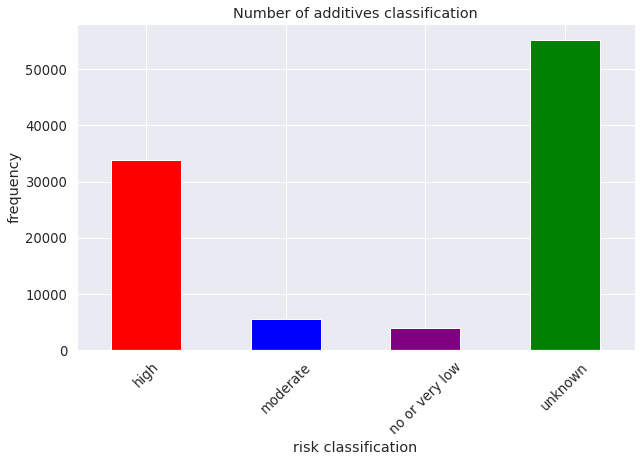

In [94]:
df_selected.groupby('additives_tags_classification')['additives_tags_classification'].count().plot(kind='bar', color=['red', 'blue', 'purple', 'green'], figsize=(10,6)) 

plt.xlabel('risk classification')
plt.ylabel('frequency')
plt.title('Number of additives classification')
plt.xticks(rotation = 45)
plt.show()

***
As we can see from the above plot (without taking into account the NaN values which are 65196 in total)
* ~55% of the available additive tags that we have are unknown
* ~34% have at least 1 high risk additive
* ~6% have at least 1 moderate risk additive
* ~4% have at least 1 low or no risk additive
***

***
### **3. Are there countries with more or less risky additives?**
***

***
To answer this question we can use the `additives_tags_classification` column that we have created above. This column holds for every entry in our dataset a flag corresponding to the risk found from the `additives lists` per entry. Because in our dataset we can have more than one country per entry, we have to loop over the countries and make a series or a dictionary that will hold per country the corresponding classification. These dictionaries will have 5 columns: `Country, High_risk, Moderate_risk, Low_risk and Unknown_risk`. Each country will be added to the dictionary and according to the `additives_tags_classification` column the corresponding key of the dictionary will get a value of 1. These dictionaries are stored in a list once we run the corresponding function in all entries of our dataframe. Like that every country is flagged with a risk. Afterwards the list can be unpacked to a new dataframe. So to answer the question if there are countries with more or less risky additives we have to groupby our new dataframe per country, aggregate the risk keys by summing up all the 1's and sort the values according to the high risk in descenting order.
***

***
1. Have a look on some values of the `countries_tags` first
***

In [95]:
df_selected['countries_tags'].unique()[0:10]

array(['en:united-states', 'en:canada', 'en:france', 'en:united-kingdom',
       'en:germany', 'en:france,en:united-kingdom',
       'en:belgium,en:france,en:netherlands,en:united-kingdom',
       'en:canada,en:france,en:switzerland,en:united-states',
       'en:france,en:united-states', 'en:belgium,en:france'], dtype=object)

***
2. Remove the prefixes `en:, fr: or nl:` and split the strings by the comma and make them a list
***

In [96]:
df_selected['countries_tags'] = df_selected['countries_tags'].replace('en:|fr:|nl:', '', regex=True).str.split(',').tolist()

***
3. Make a new dataframe that will hold only the `countries_tags` and the `additives_tags_classification` without taking into account the NaN values. Reset the index and drop the second one that is called "index".
***

In [97]:
df_countries_classification = df_selected[['countries_tags', 'additives_tags_classification']].copy()
df_countries_classification.dropna(axis=0, how='any', inplace=True)
df_countries_classification.reset_index(inplace=True)
df_countries_classification.drop(axis=1,columns=['index'], inplace=True)
# Check the type if it is a list
#df_countries_classification.applymap(lambda x: isinstance(x,list)).all()

***
3. Define a function that will take the list of countries, the risk-classification and an empty list. A dictionary that holds the country name, the corresponding  risk flag and "counts" the same time the number of products sold in this country is created and afterwards it is appended to the empty list that we passed as an argument on the function. 
***

In [98]:
def assign_countries_to_risks(list_countries, classification, data_list):
    
    high_risk = 0
    moderate_risk = 0
    low_risk = 0
    unknown_risk = 0
    
    for country in list_countries:

        if classification=='high':
            high_risk=1
        elif classification=='moderate':
            moderate_risk=1
        elif classification=='no or very low':
            low_risk=1
        elif classification=='unknown':
            unknown_risk=1   

        d = {'Country': country, 
            'High_risk': high_risk, 
            'Moderate_risk': moderate_risk, 
            'Low_risk': low_risk,
            'Unknown_risk':unknown_risk,
            'Num_of_products' : 1
        }     
        
        data_list.append(d)

***
4. Run the function to get the list of the dictionaries and convert this list to a dataframe. 
***

In [99]:
# Create an empty list to pass the dictionaries 
datalist=[]

# Unpack countries and the classification
df_countries_classification.apply(
    lambda x: assign_countries_to_risks(x['countries_tags'], x['additives_tags_classification'], datalist), axis=1)

# Convert list to dataframe
df_riskOfAdditives = pd.DataFrame(datalist) 

***
5. Group the new dataframe by country and aggregate the risks by summing up all the 1's
***

In [100]:
df_riskOfAdditives2 = df_riskOfAdditives.groupby(['Country']).agg({'High_risk': 'sum', 'Moderate_risk': 'sum', 'Low_risk': 'sum', 'Unknown_risk': 'sum'})
df_riskOfAdditives2 = df_riskOfAdditives2.sort_values("High_risk", ascending=False)
df_riskOfAdditives2.head(12)

,High_risk,Moderate_risk,Low_risk,Unknown_risk
Country,,,,
united-states,23332,4638,3402,39310
france,8700,747,481,12900
switzerland,1070,94,68,1832
spain,379,46,14,469
united-kingdom,294,21,24,458
belgium,252,17,7,325
germany,161,26,16,436
portugal,92,5,2,83
canada,46,6,1,73


***
6. Group the new dataframe by country and sumup all the products sold by country
***

In [101]:
df_productspercountry = df_riskOfAdditives.groupby(['Country']).agg({'Num_of_products':'sum'})
df_productspercountry.sort_values('Num_of_products', ascending=False, inplace=True)
df_productspercountry.head(12)

,Num_of_products
Country,
united-states,70682
france,22828
switzerland,3064
spain,908
united-kingdom,797
germany,639
belgium,601
portugal,182
italy,155


***
6. Plot the top 10 countries where products with risky additives are sold and at the same time plot the number of products sold per country.
***

<Figure size 432x288 with 0 Axes>

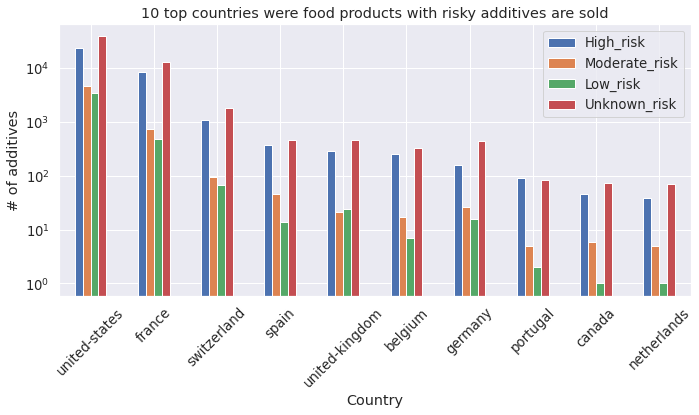

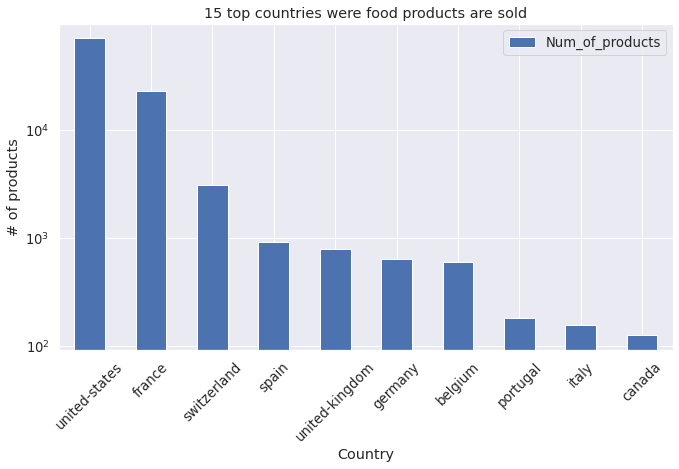

In [102]:
#plot1 = plt.figure(1, figsize=(10,6))
plot1 = plt.figure(1)
plt.tight_layout()
df_riskOfAdditives2.iloc[0:10,:].plot(kind='bar', figsize=(10,6));
plt.title('10 top countries were food products with risky additives are sold');
plt.ylabel('# of additives');
plt.xticks(rotation = 45);
plt.yscale('log');

plot2 = plt.figure(2)
plt.tight_layout()
df_productspercountry.iloc[0:10,:].plot(kind='bar', figsize=(11,6));
plt.title('15 top countries were food products are sold');
plt.ylabel('# of products');
plt.xticks(rotation = 45);
plt.yscale('log');


plt.show()

***
If we have a look on both plots we see that for the first 5 countries (US, FR, CH, ES and UK) the number of products sold on these countries is highly correlated also with the number of high risk additives that these products have. This correlation is not any more valid when we look at the next 5 countries. This is due to the fact that the products still have additives but most of them are not classified as high-risk.  
***

***
### **4. Which product categories have more risky additives?**
***

***
1. To answer this question we can have a quick look on the categorical columns: `categories_tags, main_category, pnns_groups_1` and `pnns_groups_2 ` which have similar information to decide which one is more general.
***

In [103]:
df_selected[['product_name','categories_tags', 'main_category', 'pnns_groups_1', 'pnns_groups_2']].loc[(df_selected['categories_tags'].notna()) &
                                                                                                        (df_selected['main_category'].notna()) &
                                                                                                        (df_selected['pnns_groups_1'].notna()) &
                                                                                                        (df_selected['pnns_groups_2'].notna())].tail(5)


,product_name,categories_tags,main_category,pnns_groups_1,pnns_groups_2
355914,blue_cheese_dressing,"en:groceries,en:sauces,en:salad-dressings",en:groceries,Fat and sauces,Dressings and sauces
355915,santa_cruz_chilli_and_lime_dressing,"en:groceries,en:sauces,en:salad-dressings",en:groceries,Fat and sauces,Dressings and sauces
355922,fisherman's_friend_miel-citron,"en:sugary-snacks,en:confectioneries,en:candies,fr:pastilles",en:sugary-snacks,Sugary snacks,Sweets
355974,treize_raisons,"en:dairies,en:milks",en:dairies,Milk and dairy products,Milk and yogurt
355977,ma_bite,"en:beverages,en:non-sugared-beverages",en:beverages,Beverages,Non-sugared beverages


***
2. Here we see 5 examples from different products. The more generic category seems to be `main_category` so we can use this one to check which category has more risky additives. We have again to remove the prefixes "en:" etc and follow the same steps that we did before to assign to the countries a flag for the risk. The steps to followed to do the aforementioned is exactly the same as before.
***

***
3. Remove the prefixes from the main category.
***

In [104]:
#df_selected['categories_tags'] = df_selected['categories_tags'].replace('en:|fr:|it:|es:|de:|nl:', '', regex=True).str.split(',').tolist()
df_selected['main_category'] = df_selected['main_category'].replace('en:|fr:|it:|es:|de:|nl:', '', regex=True)

***
4. Define a function that will take as input the product category, the risk-classification an empty list to be filled in after assigning to each product category a flag for the risk of additives.
***

In [105]:
def assign_product_category_to_risks(product_cat, classification, data_list):
    
    high_risk = 0
    moderate_risk = 0
    low_risk = 0
    unknown_risk = 0
    
   # for product in list_products:

    if classification=='high':
        high_risk=1
    elif classification=='moderate':
        moderate_risk=1
    elif classification=='no or very low':
        low_risk=1
    elif classification=='unknown':
        unknown_risk=1   

    d = {'Product_category': product_cat, 
        'High_risk': high_risk, 
        'Moderate_risk': moderate_risk, 
        'Low_risk': low_risk,
        'Unknown_risk':unknown_risk
    }     

    data_list.append(d)

***
5. Create a new dataframe that holds only the `main_category` and `additives_tags_classification`. Drop the NaN values and reset the index.
***

In [106]:
df_product_classification = df_selected[['main_category', 'additives_tags_classification']].copy()
df_product_classification.dropna(axis=0, how='any', inplace=True)
df_product_classification.reset_index(inplace=True)
df_product_classification.drop(axis=1,columns=['index'], inplace=True)
#df_product_classification.head(10)

***
6. Run the function `assign_product_category_to_risks` and pass the results to list and afterwards convert this list to a dataframe.
***

In [107]:
# Create an empty list to pass the dictionaries 
productlist=[]

# Unpack products and the classification
df_product_classification.apply(
    lambda x: assign_product_category_to_risks(x['main_category'], x['additives_tags_classification'], productlist), axis=1)

# Convert list to dataframe
df_product_classification = pd.DataFrame(productlist) 

***
7. Groupy by the new dataframe by the `Product_category` and sumup all the flags. Sort the values by the `High_risk` flag in descending order to inorder to check the top 15 product categories per risky additives. 
*** 

In [108]:
df_product_classification2 = df_product_classification.groupby(['Product_category']).agg({'High_risk': 'sum', 'Moderate_risk': 'sum', 'Low_risk': 'sum', 'Unknown_risk': 'sum'})
df_product_classification2 = df_product_classification2.sort_values("High_risk", ascending=False)
df_product_classification2.head(15)

,High_risk,Moderate_risk,Low_risk,Unknown_risk
Product_category,,,,
sugary-snacks,1551,128,112,2896
plant-based-foods-and-beverages,925,196,37,3380
meats,785,2,17,91
beverages,696,122,92,1064
fresh-foods,665,6,29,331
meals,512,43,19,412
dairies,502,21,31,435
frozen-foods,366,14,16,320
groceries,357,31,23,555


***
8. Plot the 15 top product categories with risky additives.
***

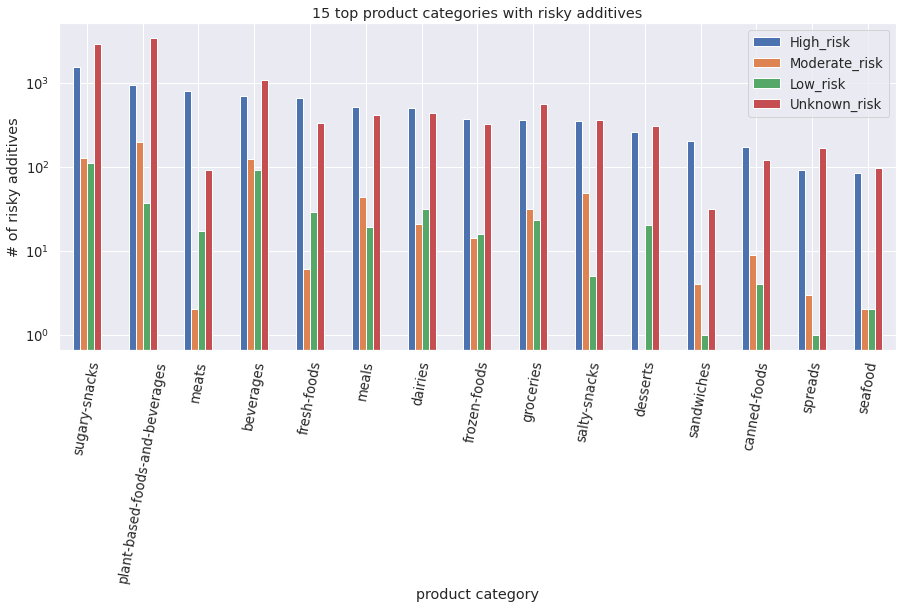

In [109]:
df_product_classification2.iloc[0:15,:].plot(kind='bar', figsize=(15,6))
plt.title('15 top product categories with risky additives')
plt.xlabel('product category')
plt.ylabel('# of risky additives')
plt.xticks(rotation = 80)
plt.yscale('log')
plt.show()

***
The top 15 product categories are ordered by the high risk additives. So here we that the `sugary-snacks` they have a lot of additives and most of them they are of high risk. 
***

***
### **5. Which product category is most prone to have many additives?**
***

***
To answer this question we can use the `main_category` and the `additives_n` columns of our dataframe. Since the `main_category` has a lot of NaN values we can pass these two columns in a new dataframe and drop them. Then we can groupby the `main_category`, sumup the `additives_n` per category and plot them.
***

In [110]:
df_product_category_nadditives = df_selected[['main_category', 'additives_n']].copy()
df_product_category_nadditives.dropna(axis=0, how='any', inplace=True)
df_product_category_nadditives.reset_index(inplace=True)
df_product_category_nadditives.drop(axis=1,columns=['index'], inplace=True)

df_product_category_nadditives = df_product_category_nadditives.groupby(['main_category']).agg({'additives_n': 'sum'}).copy()
df_product_category_nadditives = df_product_category_nadditives.sort_values("additives_n", ascending=False)
df_product_category_nadditives.head(10)

,additives_n
main_category,
sugary-snacks,17183.0
plant-based-foods-and-beverages,10525.0
beverages,5940.0
fresh-foods,3855.0
dairies,3287.0
meals,3203.0
desserts,2951.0
meats,2692.0
groceries,2601.0


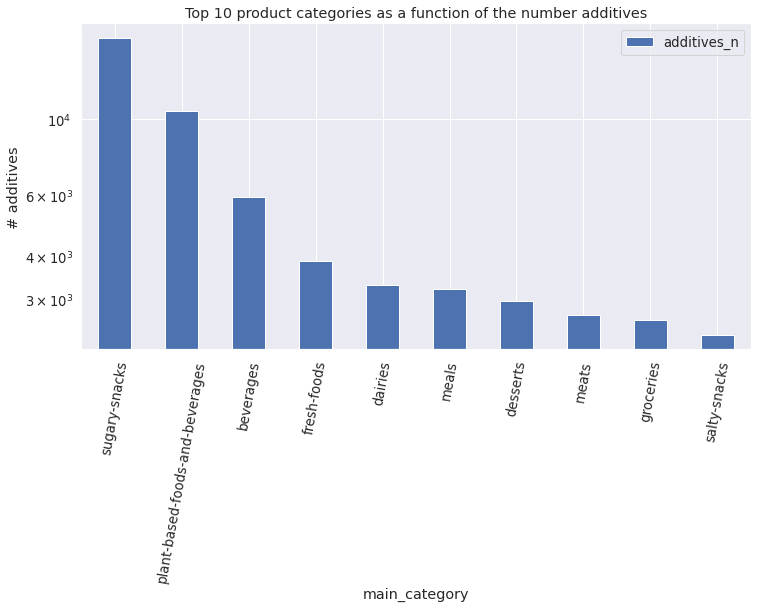

In [111]:
df_product_category_nadditives.iloc[0:10,:].plot(kind='bar', figsize=(12,6))
plt.title('Top 10 product categories as a function of the number additives')
plt.ylabel('# additives')
plt.xticks(rotation = 80)
plt.yscale('log')
plt.show()

***
As we see the `sugary-snacks` and the `plant=based-foods-and-beverages` they come first as the products that have many additives. As we saw earlier, these were also the top 2 categories with high risk additives. 
***

***
# **<span style="color:blue">Task C: Text Data**</span>
***

***
### **Which are the five most common ingredients?**
***

***
To answer this question we can group our dataframe by the column `ingredients_text`, drop the NaN values and sort the values by descending order. But since we know that that this column is still quite messy as there are the same ingredients written in a bit different way and even in different language what we can do is to have a look for e.g. on the first top 20 ingredients and aggragate those that are essential the same or similar. 
***

In [112]:
df_ingredients = df_selected.groupby('ingredients_text', dropna=True).size().sort_values(ascending=False)
df_ingredients2 = df_ingredients.head(20).to_frame()
df_ingredients2

# we can get the same result if we use after droping the NaN's:
# df_selected['ingredients_text'].value_counts()[:20].sort_values(ascending=False)

,0
ingredients_text,
semoule de blé dur de qualité supérieure,141
almonds,118
100% semoule de blé dur de qualité supérieure,118
"semolina (wheat), durum flour (wheat), niacin, ferrous sulfate (iron), thiamin mononitrate, riboflavin, folic acid",109
walnuts,98
pecans,87
"semoule de blé dur, eau",64
corn,62
"pasteurized milk, cheese culture, salt, enzymes",62


***
As we see above:
* the wheat semolina is found in 9 different entries, written in french or english with additives or not
* the pasterized milk and cheese are also found in 2 entries written a bit different, etc.

But we can aggregate all these similarities and create a new dictionary to have a more clean result. 
***

In [113]:
durum_wheat_semolina = df_ingredients2.loc[['semoule de blé dur de qualité supérieure',
                                            '100% semoule de blé dur de qualité supérieure',
                                            'semoule de blé dur, eau',
                                            'semolina (wheat), durum flour (wheat), niacin, ferrous sulfate (iron), thiamin mononitrate, riboflavin, folic acid',
                                            'durum wheat semolina',
                                            'semolina, niacin, ferrous sulfate (iron), thiamin mononitrate, riboflavin, folic acid',
                                            'organic durum wheat semolina',
                                            'durum semolina, niacin, ferrous sulfate (iron), thiamine mononitrate, riboflavin, folic acid',
                                            'semoule de blé dur']].sum()

milk_cheese = df_ingredients2.loc[['pasteurized milk, cheese culture, salt, enzymes', 
                                   'pasteurized part-skim milk, cheese culture, salt, enzymes']].sum()

nuts = df_ingredients2.loc[['walnuts','pecans','almonds']].sum()


dict_ingredients = {'durum wheat semolina': durum_wheat_semolina[0], 
                    'nuts': nuts[0],
                    'pasteurized milk, cheese': milk_cheese[0],
                    'corn': df_ingredients2.loc['corn'][0],
                    'broccoli':df_ingredients2.loc['broccoli'][0],
                    'beef':df_ingredients2.loc['beef'][0],
} 

pd.DataFrame.from_dict(dict_ingredients, orient='index')

,0
durum wheat semolina,704
nuts,303
"pasteurized milk, cheese",110
corn,62
broccoli,57
beef,56


***
Here we display the 6 most common ingredients that we found by just looking though only on 20 entries of our initial dataframe. 
***

***
# **<span style="color:blue">Task D: Time-Series Analysis</span>**
***

***
In order to perform a time-series analysis we have first to convert the columns `created_datetime` and `last_modified_datetime` into datetime since their dtype is object. 

In addition, for this task, I will create a new dataframe with the following columns
* the above mentioned `datetimes`, 
* the time difference between the datetimes (`Timedelta_days`) 
* the `period` (in months) from the created_datetime column
* the `product_name` which will be needed in order to count the total number of items created each month
***

In [114]:
# Convert the datetime columns from object to datetime
df_selected['created_datetime'] = pd.to_datetime(df_selected['created_datetime'])
df_selected['last_modified_datetime'] = pd.to_datetime(df_selected['last_modified_datetime'])

print('dtype "created_datetime": ', df_selected['created_datetime'].dtypes)
print('dtype "last_modified_datetime": ', df_selected['last_modified_datetime'].dtypes)

dtype "created_datetime":  datetime64[ns, UTC]
dtype "last_modified_datetime":  datetime64[ns, UTC]


In [115]:
# create a new dataframe 
df_products_registered = df_selected[['created_datetime','last_modified_datetime', 'product_name']].copy()

# add a new column for the time difference between created and last_modified datetimes
df_products_registered['Timedelta_days']=df_products_registered['last_modified_datetime']-df_products_registered['created_datetime']

# add a column which will hold the periods in Months from the created_datetime column
df_products_registered.set_index('created_datetime', inplace=True)
df_products_registered['Period_created'] = df_products_registered.index.tz_localize(None).to_period("M") # tz_localize(None) needed to suppress UserWarning: Converting
#to PeriodArray/Index representation will drop timezone information UserWarning,

# reset index
df_products_registered.reset_index(inplace=True)

df_products_registered.head(2)

,created_datetime,last_modified_datetime,product_name,Timedelta_days,Period_created
0,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,banana_chips_sweetened_whole,0 days,2017-03
1,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,peanuts,0 days,2017-03


In [116]:
# check the dtypes of the columns
df_products_registered.dtypes

created_datetime          datetime64[ns, UTC]
last_modified_datetime    datetime64[ns, UTC]
product_name                           object
Timedelta_days                timedelta64[ns]
Period_created                      period[M]
dtype: object

***
### **What is the mean time difference between the `created_datetime` and the `last_modified_datetime` columns?**
***

***
1. We see that the `Timedelta_days` column is a timedelta object and we can look on the discription of this column to get the statistics. 
*** 

In [117]:
df_products_registered['Timedelta_days'].describe()

count                         150751
mean     101 days 09:57:32.423963828
std      293 days 11:50:41.733626832
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  0 days 00:00:00
75%           0 days 00:10:36.500000
max               2015 days 05:45:37
Name: Timedelta_days, dtype: object

***
2. The `mean time` difference between the created and last_modified datetime is `101 days and ~10 hours` with a `standard deviation of 293 days and ~12 hours`. And the timedelta difference spans from 0 up to max 2015 days and we can have a look also on this distribution. 
***

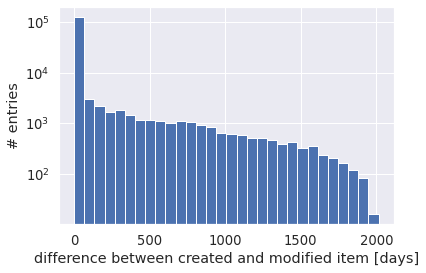

In [118]:
df_products_registered['Timedelta_days'].dt.days.hist(bins=30)# each bin is ~67 days
plt.xlabel("difference between created and modified item [days]")
plt.ylabel("# entries")
plt.yscale('log')
plt.show()

***
In the above histogram, each bin corresponds to $\sim$67 days (a bit more than 2 months). In the first bin we have $\sim$10$^5$ entries ($\sim$70% of our data) while the remaining $\sim$30% of our data are distributted in a time difference from $\sim$2 months up to $\sim$5.5 years maximum.
***

***
### **What are the total number of items created each month over the full timeline?**
***

***
To answer this question we can groupby the `Period_created` column, count the `products` per month and visualize our findings.
***

In [119]:
# Group by period and count the products created per month
df_products_per_period = df_products_registered.groupby('Period_created')['product_name'].count().to_frame().copy()
df_products_per_period.rename(columns={'product_name':'total_products'}, inplace=True)

df_products_per_period.tail(2)

,total_products
Period_created,
2017-08,2208
2017-09,1204


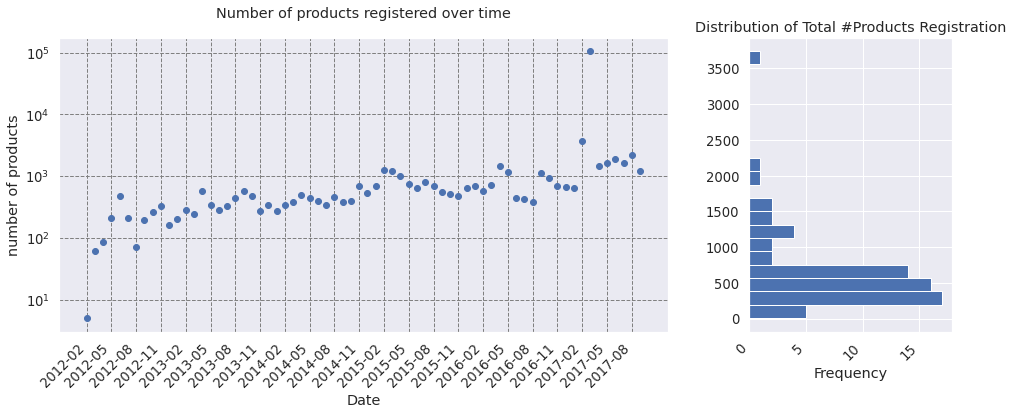

In [120]:
fig, ax = plt.subplots(1,2,figsize=(16, 6),gridspec_kw={'width_ratios': [3, 1]})

# plot the number of products registered over time
ax[0].scatter(df_products_per_period.index.astype(dtype=str), df_products_per_period['total_products'])
ax[0].set_title("Number of products registered over time", pad=20) # pad is used to adjust the title wrt to the figure
ax[0].set_ylabel("number of products")
ax[0].set_xlabel("Date")
ax[0].set_xticks(np.arange(0,df_products_per_period.shape[0],step=3));
fig.autofmt_xdate(rotation= 45)
ax[0].grid(color='grey', linestyle='--') 
ax[0].set_yscale('log')

# plot the distribution excluding the 10^5 products created in the beginning of 2017
ax[1].set_title('Distribution of Total #Products Registration')
ax[1].set_xlabel('Frequency')
ax[1].hist(df_products_per_period['total_products'][df_products_per_period['total_products']<10000],bins=20,orientation='horizontal')

plt.show()

***
As as we from the above two plots:
* the first few products (<10) were registered on Feb. 2012 
* from March 2012 and up to Sept.2019 there was an upward increase of the number of products registered per month spanning from a bit less than 100 products/month up to a bit more than about 1000 products/month
* on March 2017 there was a registration of about 10$^5$ products

We can also visualize better this upward increase of the products registered per month up to the beginning of 2017:
***

In [121]:
# select periods from the beginning up to Jan.2017
df_products_per_period_selected=df_products_per_period['2012-02':'2017-01']

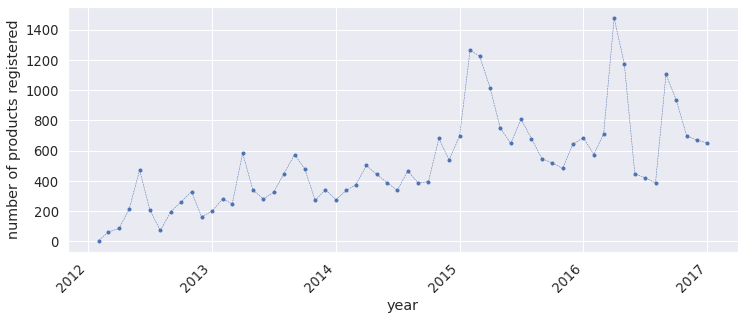

In [122]:
fig, ax = plt.subplots(1, figsize=(12, 5))

# Plot the prices
ax.plot(df_products_per_period_selected.to_timestamp(), marker='.', linewidth=0.5, linestyle='--')
ax.set_xlabel('year')
ax.set_ylabel('number of products registered')
fig.autofmt_xdate(rotation= 45)

plt.show()


***
And we can also look on the monthly changes on the registration of the products over time.
***

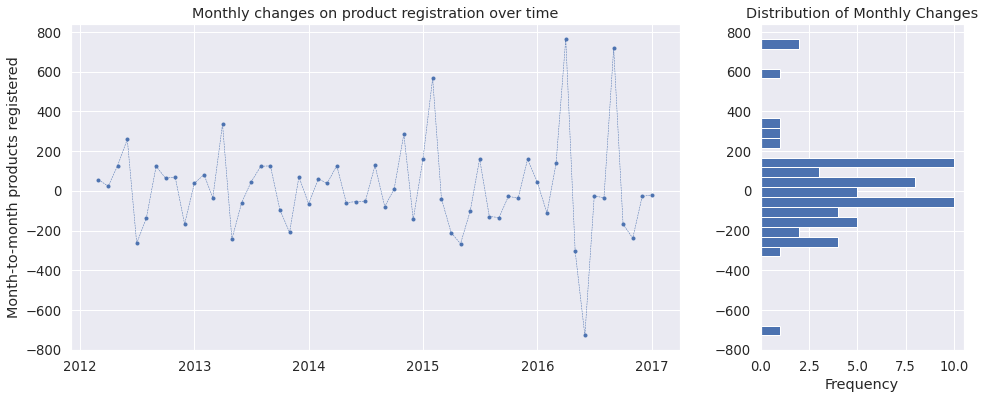

In [123]:
# Compute the difference
diff = df_products_per_period_selected - df_products_per_period_selected.shift(1)

fig, ax = plt.subplots(1,2,figsize=(16, 6),gridspec_kw={'width_ratios': [3, 1]})

ax[0].plot(diff.to_timestamp(), marker='.', linewidth=0.5, linestyle='--')
ax[0].set_title('Monthly changes on product registration over time')
ax[0].set_ylabel('Month-to-month products registered')

ax[1].hist(diff,bins=30,orientation='horizontal')
ax[1].set_title('Distribution of Monthly Changes')
ax[1].set_xlabel('Frequency')

plt.show()


***
From the difference between consecutive months, we see that the number of products registered fluctuates on average around 200 with some periods having two to three times more products registered. 
***

***
# **<span style="color:blue">Task E: Build a database</span>**
***

In [124]:
import sqlite3

***
### **1. Create a database `nutrition.db`**
***

In [148]:
db = sqlite3.connect("nutrition.db")

In [149]:
def run_query(query):
    return pd.read_sql_query(query,db)

***
### **2. Create the 1st table called "products" with the primary key**
***

In [150]:
query= '''
CREATE TABLE IF NOT EXISTS products (ID INTEGER PRIMARY KEY, 
                                     code INTEGER PRIMARY KEY,
                                     main_category TEXT,
                                     nutrition_score INTEGER,
                                     additives_n INTEGER,
                                     energy FLOAT);'''

In [151]:
cursor = db.cursor()
cursor.execute(query)

***
### **3. Check that the table has been created**
***

In [152]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
results = cursor.fetchall()
print(results)

[('products',)]


***
### **4. Insert into the table `products` the corresponding data from the dataframe**
***

In [153]:
df_selected2 = df_selected[['code', 'main_category', 'nutrition-score-fr_100g', 'additives_n', 'energy_100g_calculated' ]].copy()
df_selected2.dropna(axis=0, how='any', inplace=True)

In [154]:
df_selected2.shape

(37080, 5)

In [155]:
# first reset the index of df_selected to take the first 1000 rows
df_selected2.reset_index(inplace=True)

In [133]:
df1 = df_selected2.loc[0:999, :].copy()
#df1.reset_index(inplace=True)
df1.rename(columns={'index':'ID',
                    'nutrition-score-fr_100g':'nutrition_score',
                    'energy_100g_calculated':'energy'}, inplace=True)
df1.head(5)

,ID,code,main_category,nutrition_score,additives_n,energy
0,176,0000000290616,plant-based-foods-and-beverages,6.0,0.0,288.00
1,182,0000001938067,sugary-snacks,9.0,5.0,264.42
2,183,0000004302544,boulange,1.0,0.0,263.19
3,185,0000007020254,beverages,18.0,3.0,56.80
4,187,0000008237798,meals,2.0,3.0,113.99


In [134]:
df1.shape

(1000, 6)

In [135]:
df1.to_sql(name='products', con=db, if_exists='append', index=False)

***
### **4. Run a query to demonstrate that it works correctly**
***

In [136]:
query = '''
SELECT nutrition_score, ROUND(AVG(energy),1) AS 'avg_energy'
FROM products
GROUP BY nutrition_score
ORDER BY nutrition_score ASC
LIMIT 5;
'''
run_query(query)

,nutrition_score,avg_energy
0,-13,63.3
1,-11,30.5
2,-10,33.0
3,-9,61.7
4,-7,165.0


***
### **5. Create one more table called `other_nutrients`**
***

In [137]:
df2 = df_selected[['code',
                   'carbohydrates_100g',
                   'sugars_100g',
                   'fiber_100g',
                   'proteins_100g',
                   'salt_100g', 
                   'sodium_100g',
                   'saturated-fat_100g',
                   'fat_100g']].loc[df_selected['main_category'].notna()].copy()
df2.reset_index(inplace=True)
df2.rename(columns={'index':'ID',
                    'saturated-fat_100g':'saturated_fat_100g'}, inplace=True)
df2 = df2.iloc[0:1000,:].copy()

In [138]:
df2.shape

(1000, 10)

In [139]:
df2.to_sql(name='other_nutrients', con=db, if_exists='replace', index=False)

### **6. Check the tables in the database**

In [140]:
run_query("SELECT tbl_name FROM sqlite_master;")

,tbl_name
0,products
1,other_nutrients


***
# **<span style="color:blue">Task F: Finding correlations</span>**
***

***
Have a look on the first entry of each table
***

In [141]:
run_query("SELECT * from products LIMIT 1")

,ID,code,main_category,nutrition_score,additives_n,energy
0,176,290616,plant-based-foods-and-beverages,6,0,288.0


In [142]:
run_query("SELECT * from other_nutrients LIMIT 1")

,ID,code,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,saturated_fat_100g,fat_100g
0,176,0000000290616,23.0,0.0,2.0,22.0,2.16,0.85,7.0,12.0


***
### **Which variables affect mostly the nutritional score**
***

In [143]:
# Select from both tables all the nutritients and avg them per nutrition score
query = '''
SELECT products.nutrition_score, 
       ROUND(AVG(other_nutrients.fat_100g),1) AS 'avg_fat', 
       ROUND(AVG(other_nutrients.saturated_fat_100g),1) AS 'avg_saturated_fat', 
       ROUND(AVG(other_nutrients.carbohydrates_100g),1) AS 'avg_carbs', 
       ROUND(AVG(other_nutrients.sugars_100g),1) AS 'avg_sugars', 
       ROUND(AVG(other_nutrients.fiber_100g),1) AS 'avg_fibers',
       ROUND(AVG(other_nutrients.proteins_100g),1) AS 'avg_proteins', 
       ROUND(AVG(other_nutrients.salt_100g),3) AS 'avg_salt',
       ROUND(AVG(other_nutrients.sodium_100g),3) AS 'avg_sodium'
FROM products, other_nutrients
WHERE products.code = other_nutrients.code
GROUP BY nutrition_score
ORDER BY nutrition_score ASC;
'''
#run_query(query)


In [144]:
# executer query
cursor.execute(query)
results = cursor.fetchall()

# copy the results query into a dataframe to plot the results
sql_data = pd.DataFrame(results, columns=['nutrition_score','avg_fat', 'avg_saturated_fat', 'avg_carbs', 'avg_sugars', 'avg_fibers','avg_proteins','avg_salt','avg_sodium'])
sql_data.set_index('nutrition_score', inplace=True)
sql_data.tail(5)

,avg_fat,avg_saturated_fat,avg_carbs,avg_sugars,avg_fibers,avg_proteins,avg_salt,avg_sodium
nutrition_score,,,,,,,,
25,24.4,13.1,63.3,45.8,0.6,4.4,0.490,0.193
26,31.3,13.6,50.4,34.5,0.6,9.6,1.511,0.595
27,27.4,20.8,62.9,57.9,0.7,5.8,0.454,0.179
28,15.0,10.0,75.0,60.0,5.0,5.0,2.160,0.850
29,0.0,0.0,15.3,15.3,0.0,0.0,11.000,4.331


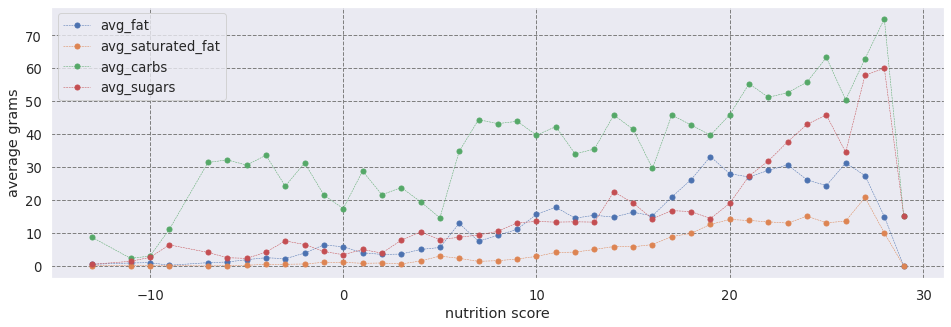

In [145]:
fig, ax = plt.subplots(1, figsize=(16, 5))

ax.plot(sql_data['avg_fat'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_fat')
ax.plot(sql_data['avg_saturated_fat'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_saturated_fat')
ax.plot(sql_data['avg_carbs'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_carbs')
ax.plot(sql_data['avg_sugars'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_sugars')

ax.set_xlabel('nutrition score')
ax.set_ylabel('average grams')
ax.grid(color='grey', linestyle='--')
ax.legend(loc="best")
plt.show()

***
As we know the fats and especially the saturated fats, as well as the carbs and especially the sugars tend to be more harmful for our health. The more grams of those nutritients are per 100g the worse is the nutrition score. The last data point though at higher nutrition score where both fats (saturated-fats) and carbs (sugars) are very low, seems to be affected by a specific product category, the `beverages`, as we see below.
***

In [146]:
query = '''
SELECT products.main_category, 
       products.nutrition_score,
       ROUND(AVG(other_nutrients.saturated_fat_100g),2) AS 'avg_saturated_fat',
       ROUND(AVG(other_nutrients.carbohydrates_100g),1) AS 'avg_carbs'
FROM products, other_nutrients
WHERE (products.code = other_nutrients.code)
GROUP BY main_category, nutrition_score
ORDER BY nutrition_score DESC
'''

run_query(query)

,main_category,nutrition_score,avg_saturated_fat,avg_carbs
0,beverages,29,0.00,15.3
1,hot-cocoa-mix,28,10.00,75.0
2,sugary-snacks,27,20.80,62.9
3,groceries,26,10.30,3.5
4,meats,26,13.00,5.0
...,...,...,...,...
347,sugary-snacks,-7,0.00,71.1
348,plant-based-foods-and-beverages,-9,0.05,11.1
349,plant-based-foods-and-beverages,-10,0.10,3.0
350,plant-based-foods-and-beverages,-11,0.10,2.3


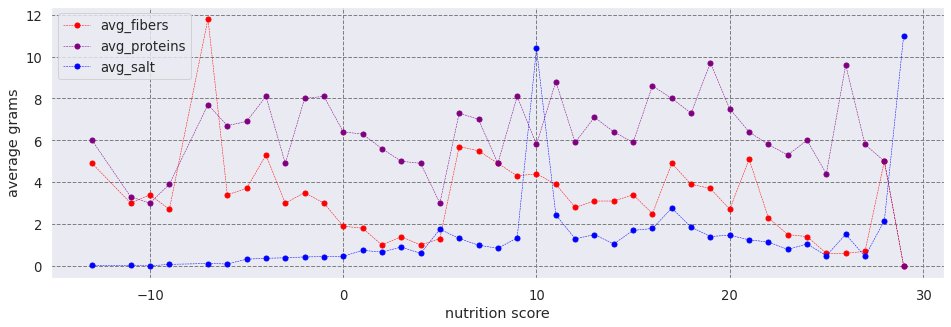

In [147]:
fig, ax = plt.subplots(1, figsize=(16, 5))

ax.plot(sql_data['avg_fibers'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_fibers', color='red')
ax.plot(sql_data['avg_proteins'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_proteins', color='purple')
ax.plot(sql_data['avg_salt'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_salt', color='blue')
#ax.plot(sql_data['avg_sodium'], marker='o', markersize=5, linewidth=0.5, linestyle='dashed', label='avg_sodium', color='k')
ax.set_xlabel('nutrition score')
ax.set_ylabel('average grams')
ax.grid(color='grey', linestyle='--')
ax.legend(loc="best")
plt.show()

From the above plot we see that the `fibers` and the `proteins` cause both a low or a high nutritional score. 